# GTHA housing market database
# OSEMN methodology Step 2: Scrub
# Step 2.2 Correction of inconsistent entries in the Teranet dataset

---

This notebook describes Step 2.2 (part of _Step 2: Scrub_ of OSEMN methodology) performed on the Teranet dataset.

Step 2.2 focuses on the correction of inconsistent entries in the Teranet dataset. Cleanup plan is presented below.

Previous steps included: 

* Step 2.1 

    * the spatial join between the Teranet points and the polygons of GTHA Dissemination Areas (DAs)
    
    * During step 2.1, Teranet records whose coordinates fall outside of the GTHA boundary (as defined by the DA geometry) have been filtered out (6,803,691 of the original 9,039,241 Teranet records remain in the dataset)
     
    * In addition to that, three new columns (`OBJECTID`, `DAUID`, and `CSDNAME`) derived from DA attributes have been added to each Teranet transaction

---

For description of OSEMN methodology, see `methodology/0.osemn/osemn.pdf`.

For background information, description of the Teranet dataset, and its attributes, see `methodology/1.obtain/obtain.pdf`.

For description of _Step 2: Scrub_ of OSEMN methodology, see `methodology/2.scrub/scrub.pdf`.

For description of the cleanup plan for the Teranet dataset, see `methodology/2.scrub/teranet_cleanup_plan.pdf`.

For description of Step 2.1 of the cleanup process, see `notebooks/2.scrub/2.1_teranet_gtha_spatial_join.ipynb`.

## Cleanup plan

1. Convert column names to lower case
2. Fix inconsistent capitalizations for values in columns:
    * `municipality`
    * `street_name`
    * `street_designation`
    * `postal_code` (do not show problems, preventive measure)
3. Remove column `province`
4. Create a reserve copy of unmodified column `street_name` -- `street_name_raw`
5. Remove municipality mentions from `street_name`
6. Parse `postal_code` from `street_name`
7. Validate consistency of values in column `postal_code`
8. Parse `unitno` from `street_name`
9. Parse `street_number` from `street_name`
10. Parse `street_direction` from `street_name`
11. Parse `street_designation` from `street_name`
12. Investigate missing values
13. Remove column `street_suffix`
14. Fix inconsistent entries in columns:
    * 14.1: `street_direction`
    * 14.2: `street_designation`
    * 14.3: `municipality`
    * 14.4: `street_name`
    * 14.5: `unitno`
    
## Import dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from time import time

sns.set()

In [2]:
data_path = '../../data/teranet/'
os.listdir(data_path)

['3_Teranet_new_cols.csv',
 '2_Teranet_consistent.csv',
 '1.2_Teranet_DA_TAZ_cols.csv',
 '1.1_Teranet_DA_cols.csv',
 'HHSaleHistory.csv',
 '3_Teranet_nonan_new_cols.csv']

## Load Teranet data

In [3]:
t = time()
df = pd.read_csv(data_path + '1.2_Teranet_DA_TAZ_cols.csv',
                 parse_dates=['registration_date'], low_memory=False)
#df = pd.read_csv(data_path + 'Teranet_with_DA_cols.csv') # parsing dates takes ~21 minutes
elapsed = time() - t
print("----- DataFrame loaded"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- DataFrame loaded
in 1,290.10 seconds (21.50 minutes)
with 6,803,756 rows
and 19 columns
-- Column names:
 Index(['lro_num', 'pin', 'consideration_amt', 'registration_date',
       'POSTAL_CODE', 'PROVINCE', 'UNITNO', 'STREET_NAME',
       'STREET_DESIGNATION', 'STREET_DIRECTION', 'MUNICIPALITY',
       'STREET_SUFFIX', 'STREET_NUMBER', 'X', 'Y', 'DAUID', 'CSDUID',
       'CSDNAME', 'TAZ_O'],
      dtype='object')


## Step 1: convert column names to lower case

In [4]:
df.columns = df.columns.str.lower()
df.columns

Index(['lro_num', 'pin', 'consideration_amt', 'registration_date',
       'postal_code', 'province', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_suffix', 'street_number', 'x', 'y', 'dauid', 'csduid',
       'csdname', 'taz_o'],
      dtype='object')

## Step 2: fix inconsistent capitalizations
Inconsistent capitalizations are fixed for values in the following columns: 
* `unitno`
* `street_name`
* `street_designaction`
* `street_direction`
* `municipality`

In [5]:
t = time()
df['municipality'] = df['municipality'].str.title()
df['street_name'] = df['street_name'].str.title()
df['street_designation'] = df['street_designation'].str.capitalize()
df['postal_code'] = df['postal_code'].str.upper()
elapsed = time() - t
print("Capitalizations were fixed! Took {0:,.2f} seconds.".format(elapsed))

Capitalizations were fixed! Took 10.50 seconds.


## Step 3: Remove column `province`

In [6]:
df = df.drop('province', axis=1)
print("Column 'province' was removed from the dataset.")

Column 'province' was removed from the dataset.


## Step 4: Create a reserve copy of unmodified column `street_name` -- `street_name_raw`

In [7]:
df['street_name_raw'] = df['street_name'].values
print("Column `street_name_raw` was created!")

Column `street_name_raw` was created!


## Step 5: Remove municipality mentions from `street_name`

#### Erase ', Mississaug' from the end of 'street_name'

In [8]:
mask1 = df['street_name'].str.contains(',\sMississaug', na=False, case=False)
df.loc[mask1, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
6131592,NaN,"130-5260 Mcfarren Blvd, Mississaug",NaN,Mississauga
6131879,NaN,"130-5260 Mcfarren Blvd, Mississaug",NaN,Mississauga
6132150,NaN,"130-5260 Mcfarren Blvd, Mississaug",NaN,Mississauga


In [9]:
df.loc[mask1, 'street_name'] = df.loc[mask1, 'street_name'].str.replace(', Mississaug', '')
df.loc[mask1, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
6131592,NaN,130-5260 Mcfarren Blvd,NaN,Mississauga
6131879,NaN,130-5260 Mcfarren Blvd,NaN,Mississauga
6132150,NaN,130-5260 Mcfarren Blvd,NaN,Mississauga


#### Erase ', Vaugh' from the end of 'street_name'

In [10]:
mask1 = df['street_name'].str.contains(',\sVaugh', na=False, case=False)
df.loc[mask1, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
4934623,NaN,"Highway 7 West, Vaughan On L4K 0H8",NaN,Richmond Hill
5042064,NaN,"Mactier Drive, Vaughan,",NaN,Vaughan
5042936,NaN,"Mactier Drive, Vaughan,",NaN,Vaughan
6388017,NaN,"510 Vellore Woods Boulevard, Vaugh",NaN,Vaughan


In [11]:
df.loc[mask1, 'street_name'] = \
    df.loc[mask1, 'street_name']\
    .str.replace(', Vaughan,', '')\
    .str.replace(', Vaughan On', '')\
    .str.replace(', Vaugh', '')
df.loc[mask1, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
4934623,NaN,Highway 7 West L4K 0H8,NaN,Richmond Hill
5042064,NaN,Mactier Drive,NaN,Vaughan
5042936,NaN,Mactier Drive,NaN,Vaughan
6388017,NaN,510 Vellore Woods Boulevard,NaN,Vaughan


## Step 6: Parse `postal_code` from `street_name`
Some Teranet records with missing `postal_code` have it as part of their `street_name` value.

In [12]:
mask1 = df['street_name'].str.contains('[A-Z]\d[A-Z]\d[A-Z]\d', na=False, case=False)
df.loc[mask1, ['street_name', 'street_designation', 'postal_code', 'municipality']]

,street_name,street_designation,postal_code,municipality
112681,Stoutt Crescent L9T9A2,Cres,L9T9A2,Milton
112950,Stoutt Crescent L9T9A2,Cres,L9T9A2,Milton
427031,Dundas St E L0R2H1,NaN,NaN,Waterdown
428286,Dundas St E L0R2H1,NaN,NaN,Waterdown
738438,Orton Pk Road M1G3H2,NaN,NaN,Toronto
738526,Orton Pk Road M1G3H2,NaN,NaN,Toronto
960520,Vines Place L4G0R6,NaN,NaN,Aurora
996186,Thorncliffe Pk Drive M4H1P3,NaN,NaN,East York
996337,Thorncliffe Pk Drive M4H1P3,NaN,NaN,East York
996422,Overlea Boulevard M4H1P2,NaN,NaN,Toronto


### Extract `postal_code` from `street_name`
#### Postal code entered with no space

In [13]:
df.loc[mask1, 'postal_code'] = \
    df.loc[mask1, 'street_name'].str.split().apply(lambda x: x[-1])
df.loc[mask1, 'street_name'] = \
    df.loc[mask1, 'street_name'].str.rsplit(' ', 1).apply(lambda x: x[0]).str.strip()
df.loc[mask1, ['street_name', 'street_designation', 'postal_code', 'municipality']]

,street_name,street_designation,postal_code,municipality
112681,Stoutt Crescent,Cres,L9T9A2,Milton
112950,Stoutt Crescent,Cres,L9T9A2,Milton
427031,Dundas St E,NaN,L0R2H1,Waterdown
428286,Dundas St E,NaN,L0R2H1,Waterdown
738438,Orton Pk Road,NaN,M1G3H2,Toronto
738526,Orton Pk Road,NaN,M1G3H2,Toronto
960520,Vines Place,NaN,L4G0R6,Aurora
996186,Thorncliffe Pk Drive,NaN,M4H1P3,East York
996337,Thorncliffe Pk Drive,NaN,M4H1P3,East York
996422,Overlea Boulevard,NaN,M4H1P2,Toronto


#### Postal code entered with a space

In [14]:
mask1 = df['street_name'].str.contains('[A-Z]\d[A-Z]\s\d[A-Z]\d', na=False, case=False)
df.loc[mask1, ['street_name', 'street_designation', 'postal_code', 'municipality']]

,street_name,street_designation,postal_code,municipality
55856,Steeles Ave W L0P 1B0,NaN,NaN,Milton
56299,Steeles Ave W L0P 1B0,NaN,NaN,Milton
56420,Steeles Ave W L0P 1B0,NaN,NaN,Milton
390476,First St L0B 1B0,NaN,NaN,Scugog
391098,First St L0B 1B0,NaN,NaN,Scugog
504938,The East Mall Street M9B 6C4,NaN,NaN,Etobicoke
505918,The East Mall Street M9B 6C4,NaN,NaN,Etobicoke
555432,Lakeshore Rd L0E 1N0,NaN,NaN,Pine Grove
555942,Lakeshore Rd L0E 1N0,NaN,NaN,Pine Grove
807111,Beach Rd L4P 2L6,NaN,NaN,Keswick


In [15]:
df.loc[mask1, 'postal_code'] = \
    df.loc[mask1, 'street_name'].str.rsplit(' ', 2)\
    .apply(lambda x: x[-2:]).apply(lambda x: ''.join(x)).str.strip()
df.loc[mask1, 'street_name'] = \
    df.loc[mask1, 'street_name'].str.rsplit(' ', 2).apply(lambda x: x[0]).str.strip()
df.loc[mask1, ['street_name', 'street_designation', 'postal_code', 'municipality']]

,street_name,street_designation,postal_code,municipality
55856,Steeles Ave W,NaN,L0P1B0,Milton
56299,Steeles Ave W,NaN,L0P1B0,Milton
56420,Steeles Ave W,NaN,L0P1B0,Milton
390476,First St,NaN,L0B1B0,Scugog
391098,First St,NaN,L0B1B0,Scugog
504938,The East Mall Street,NaN,M9B6C4,Etobicoke
505918,The East Mall Street,NaN,M9B6C4,Etobicoke
555432,Lakeshore Rd,NaN,L0E1N0,Pine Grove
555942,Lakeshore Rd,NaN,L0E1N0,Pine Grove
807111,Beach Rd,NaN,L4P2L6,Keswick


## Step 7: validate consistency of values in column `postal_code`
Column `postal_code` has been validated to contain the correct data format (Canadian postal codes).

570'326 values are missing, the rest follow the correct data format.

In [16]:
df['postal_code'].str.match('^[A-Z]\d[A-Z]\d[A-Z]\d$')\
    .value_counts(dropna=False)

True    6233369
NaN      570387
Name: postal_code, dtype: int64

## Step 8: Parse `unitno` from `street_name`
Some Teranet records with missing `unitno` have it as part of their `street_name` value.

In [17]:
mask1 = df['street_name'].str.contains('Unit', na=False, case=False)
mask2 = df['street_name'].str.contains('(Unity|Unita|United|Munition)', na=False, case=False)
df.loc[mask1 & ~mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,unitno,street_name,street_designation,municipality
36612,NaN,"Speers Road, Unit 2006",NaN,Oakville
36614,NaN,"Speers Road, Unit 2006",NaN,Oakville
36615,NaN,"Speers Road, Unit 2006",NaN,Oakville
37029,NaN,"Speers Road, Unit 2006",NaN,Oakville
37031,NaN,"Speers Road, Unit 2006",NaN,Oakville
37032,NaN,"Speers Road, Unit 2006",NaN,Oakville
72972,NaN,"Preserve Drive, Unit 4",Dr,Oakville
72995,NaN,"Preserve Drive, Unit 13",Dr,Oakville
73069,NaN,"Sarah Cline Drive, Unit 4",Dr,Oakville
73073,NaN,"Ellen Davidson Drive, Unit 5",Dr,Oakville


### Extract `unitno` from `street_name`
#### Split by ','

In [18]:
mask1 = df['street_name'].str.contains('Unit', na=False, case=False)
mask2 = df['street_name'].str.contains('(Unity|Unita|United|Munition)', na=False, case=False)
mask3 = df['street_name'].str.contains(',')
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,unitno,street_name,street_designation,municipality
36612,NaN,"Speers Road, Unit 2006",NaN,Oakville
36614,NaN,"Speers Road, Unit 2006",NaN,Oakville
36615,NaN,"Speers Road, Unit 2006",NaN,Oakville
37029,NaN,"Speers Road, Unit 2006",NaN,Oakville
37031,NaN,"Speers Road, Unit 2006",NaN,Oakville
37032,NaN,"Speers Road, Unit 2006",NaN,Oakville
72972,NaN,"Preserve Drive, Unit 4",Dr,Oakville
72995,NaN,"Preserve Drive, Unit 13",Dr,Oakville
73069,NaN,"Sarah Cline Drive, Unit 4",Dr,Oakville
73073,NaN,"Ellen Davidson Drive, Unit 5",Dr,Oakville


In [19]:
df.loc[mask1 & ~mask2 & mask3, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name']\
    .str.split(',').apply(lambda x: x[-1]).str.replace('Unit', '').str.strip()
df.loc[mask1 & ~mask2 & mask3, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split(',')\
    .apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
36612,2006,Speers Road,NaN,Oakville
36614,2006,Speers Road,NaN,Oakville
36615,2006,Speers Road,NaN,Oakville
37029,2006,Speers Road,NaN,Oakville
37031,2006,Speers Road,NaN,Oakville
37032,2006,Speers Road,NaN,Oakville
72972,4,Preserve Drive,Dr,Oakville
72995,13,Preserve Drive,Dr,Oakville
73069,4,Sarah Cline Drive,Dr,Oakville
73073,5,Ellen Davidson Drive,Dr,Oakville


### Extract `unitno` from `street_name`
#### Split by '-'

In [20]:
mask1 = df['street_name'].str.contains('Unit', na=False, case=False)
mask2 = df['street_name'].str.contains('(Unity|Unita|United|Munition)', na=False, case=False)
mask3 = df['street_name'].str.contains('-')
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,unitno,street_name,street_designation,municipality
931035,NaN,George Street - Parking Unit,St,Toronto
931774,NaN,George Street - Parking Unit,St,Toronto
933500,NaN,George Street - Parking Unit,St,Toronto
935182,NaN,George Street - Parking Unit,St,Toronto
935858,NaN,George Street - Parking Unit,St,Toronto
1561950,NaN,St. Joseph Street-Locker Unit,NaN,Toronto
1561951,NaN,St. Joseph Street-Locker Unit,NaN,Toronto
1561952,NaN,St. Joseph Street-Locker Unit,NaN,Toronto
1561953,NaN,St. Joseph Street-Locker Unit,NaN,Toronto
2146767,NaN,Bathurst Street-Storage Unit,NaN,Toronto


In [21]:
df.loc[mask1 & ~mask2 & mask3, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name']\
    .str.split('-').apply(lambda x: x[-1])\
    .str.replace('Unit', '')\
    .str.replace('10', 'H-10').str.strip()
df.loc[mask1 & ~mask2 & mask3, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name']\
    .str.split('-').apply(lambda x: x[0])\
    .str.replace('Unit H', '').str.strip()
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
931035,Parking,George Street,St,Toronto
931774,Parking,George Street,St,Toronto
933500,Parking,George Street,St,Toronto
935182,Parking,George Street,St,Toronto
935858,Parking,George Street,St,Toronto
1561950,Locker,St. Joseph Street,NaN,Toronto
1561951,Locker,St. Joseph Street,NaN,Toronto
1561952,Locker,St. Joseph Street,NaN,Toronto
1561953,Locker,St. Joseph Street,NaN,Toronto
2146767,Storage,Bathurst Street,NaN,Toronto


### Extract `unitno` from `street_name`
#### Split by '.'

In [22]:
mask1 = df['street_name'].str.contains('Unit', na=False, case=False)
mask2 = df['street_name'].str.contains('(Unity|Unita|United|Munition|St\.\sClair)', na=False, case=False)
mask3 = df['street_name'].str.contains('\.')
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,unitno,street_name,street_designation,municipality
195541,NaN,Fairview St. Unit 77,St,Burlington
195542,NaN,Fairview St. Unit 77,St,Burlington
195543,NaN,Fairview St. Unit 77,St,Burlington
195657,NaN,Fairview St. Unit 77,St,Burlington
195658,NaN,Fairview St. Unit 77,St,Burlington
195659,NaN,Fairview St. Unit 77,St,Burlington
195966,NaN,Fairview St. Unit 77,St,Burlington
196058,NaN,Fairview St. Unit 77,St,Burlington
196264,NaN,Fairview St. Unit 77,St,Burlington
196265,NaN,Fairview St. Unit 77,St,Burlington


In [23]:
df.loc[mask1 & ~mask2 & mask3, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name']\
    .str.split('.').apply(lambda x: x[-1])\
    .str.replace('Unit', '').str.strip()
df.loc[mask1 & ~mask2 & mask3, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name']\
    .str.split('.').apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
195541,77,Fairview St,St,Burlington
195542,77,Fairview St,St,Burlington
195543,77,Fairview St,St,Burlington
195657,77,Fairview St,St,Burlington
195658,77,Fairview St,St,Burlington
195659,77,Fairview St,St,Burlington
195966,77,Fairview St,St,Burlington
196058,77,Fairview St,St,Burlington
196264,77,Fairview St,St,Burlington
196265,77,Fairview St,St,Burlington


### Extract `unitno` from `street_name`
#### Specified in (brackets)

In [24]:
mask1 = df['street_name'].str.contains('Unit', na=False, case=False)
mask2 = df['street_name'].str.contains('(Unity|Unita|United|Munition)', na=False, case=False)
mask3 = df['street_name'].str.contains('\(')
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,unitno,street_name,street_designation,municipality
1004936,NaN,Yonge Street (Parking Unit),NaN,Aurora
2091157,NaN,Peter Street (Storage Unit),NaN,Toronto
2225607,NaN,Robinson Street (Dwelling Unit),NaN,Hamilton
3274240,NaN,Shuter Street (Storage Unit),NaN,Toronto
3555310,NaN,Abell Street (Parking Unit),NaN,Toronto
3836489,NaN,York Street (Parking Unit),St,Toronto
3839933,NaN,York Street (Parking Unit),St,Toronto
5035364,NaN,Powseland Crescent (Parking Unit),NaN,Vaughan
5035669,NaN,Powseland Crescent (Parking Unit),NaN,Vaughan
5035921,NaN,Powseland Crescent (Parking Unit),NaN,Vaughan


In [25]:
df.loc[mask1 & ~mask2 & mask3, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name']\
    .str.split('(').apply(lambda x: x[-1]).str.replace(')', '')\
    .str.replace('Unit', '').str.strip()
df.loc[mask1 & ~mask2 & mask3, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split('(')\
    .apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1004936,Parking,Yonge Street,NaN,Aurora
2091157,Storage,Peter Street,NaN,Toronto
2225607,Dwelling,Robinson Street,NaN,Hamilton
3274240,Storage,Shuter Street,NaN,Toronto
3555310,Parking,Abell Street,NaN,Toronto
3836489,Parking,York Street,St,Toronto
3839933,Parking,York Street,St,Toronto
5035364,Parking,Powseland Crescent,NaN,Vaughan
5035669,Parking,Powseland Crescent,NaN,Vaughan
5035921,Parking,Powseland Crescent,NaN,Vaughan


### Extract `unitno` from `street_name`
#### Specified at the end of the string

In [26]:
mask1 = df['street_name'].str.contains('Unit', na=False, case=False)
mask2 = df['street_name'].str.contains('(Unity|Unita|United|Munition)', na=False, case=False)
df.loc[mask1 & ~mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,unitno,street_name,street_designation,municipality
911392,6,Nantucket Blvd Units 5,NaN,Toronto
911393,6,Nantucket Blvd Units 5,NaN,Toronto
2068804,NaN,Victoria Park Avenue Unit 1808,NaN,Toronto
2069037,NaN,Victoria Park Avenue Unit 1808,NaN,Toronto
2069418,NaN,Victoria Park Avenue Unit 1808,NaN,Toronto
2577668,NaN,Upper Wentworth Street Unit 21,NaN,Hamilton
2578065,NaN,Upper Wentworth Street Unit 21,NaN,Hamilton
2578066,NaN,Upper Wentworth Unit 13,NaN,Hamilton
2578269,NaN,Upper Wentworth Unit 13,NaN,Hamilton
2578326,NaN,Upper Wentworth Street Unit 21,NaN,Hamilton


In [27]:
df.loc[mask1 & ~mask2, 'unitno'] = \
    df.loc[mask1 & ~mask2, 'street_name']\
        .str.rsplit(' ', 2).apply(lambda x: x[-2:])\
        .apply(lambda x: ' '.join(x))\
        .str.replace('Unit', '')\
        .str.replace('s', 'Units')\
        .str.strip()
df.loc[mask1 & ~mask2, 'street_name'] = \
    df.loc[mask1 & ~mask2, 'street_name']\
        .str.rsplit(' ', 2).apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
911392,Units 5,Nantucket Blvd,NaN,Toronto
911393,Units 5,Nantucket Blvd,NaN,Toronto
2068804,1808,Victoria Park Avenue,NaN,Toronto
2069037,1808,Victoria Park Avenue,NaN,Toronto
2069418,1808,Victoria Park Avenue,NaN,Toronto
2577668,21,Upper Wentworth Street,NaN,Hamilton
2578065,21,Upper Wentworth Street,NaN,Hamilton
2578066,13,Upper Wentworth,NaN,Hamilton
2578269,13,Upper Wentworth,NaN,Hamilton
2578326,21,Upper Wentworth Street,NaN,Hamilton


### Extract `unitno` from `street_name`
#### Specified as 'Suite'

In [28]:
mask1 = df['street_name'].str.contains('Suite', na=False, case=False)
df.loc[mask1, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
764920,NaN,"Charles Street East, Suite 1903",NaN,Toronto
764924,NaN,"Charles Street East, Suite 2906",NaN,Toronto
764950,NaN,"Charles Street East, Suite 1709",NaN,Toronto
764977,NaN,"Charles Street East, Suite 1705",NaN,Toronto
765011,NaN,"Charles Street East, Suite 602",NaN,Toronto
765267,NaN,"Charles Street East, Suite 3508",NaN,Toronto
765280,NaN,"Charles Street East, Suite 4705",NaN,Toronto
765341,NaN,"Charles Street East, Suite 4806",NaN,Toronto
765389,NaN,"Charles Street East, Suite 5206",NaN,Toronto
772167,NaN,"Vanderhoof Avenue, Suite 415",NaN,Toronto


#### Split by ','

In [29]:
mask1 = df['street_name'].str.contains('Suite', na=False, case=False)
mask2 = df['street_name'].str.contains(',', na=False, case=False)
df.loc[mask1 & mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
764920,NaN,"Charles Street East, Suite 1903",NaN,Toronto
764924,NaN,"Charles Street East, Suite 2906",NaN,Toronto
764950,NaN,"Charles Street East, Suite 1709",NaN,Toronto
764977,NaN,"Charles Street East, Suite 1705",NaN,Toronto
765011,NaN,"Charles Street East, Suite 602",NaN,Toronto
765267,NaN,"Charles Street East, Suite 3508",NaN,Toronto
765280,NaN,"Charles Street East, Suite 4705",NaN,Toronto
765341,NaN,"Charles Street East, Suite 4806",NaN,Toronto
765389,NaN,"Charles Street East, Suite 5206",NaN,Toronto
772167,NaN,"Vanderhoof Avenue, Suite 415",NaN,Toronto


In [30]:
df.loc[mask1 & mask2, 'unitno'] = \
    df.loc[mask1 & mask2, 'street_name'].str.split(',').apply(lambda x: x[-1]).str.strip()
df.loc[mask1 & mask2, 'street_name'] = \
    df.loc[mask1 & mask2, 'street_name'].str.split(',').apply(lambda x: x[0]).str.strip()
df.loc[mask1 & mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
764920,Suite 1903,Charles Street East,NaN,Toronto
764924,Suite 2906,Charles Street East,NaN,Toronto
764950,Suite 1709,Charles Street East,NaN,Toronto
764977,Suite 1705,Charles Street East,NaN,Toronto
765011,Suite 602,Charles Street East,NaN,Toronto
765267,Suite 3508,Charles Street East,NaN,Toronto
765280,Suite 4705,Charles Street East,NaN,Toronto
765341,Suite 4806,Charles Street East,NaN,Toronto
765389,Suite 5206,Charles Street East,NaN,Toronto
772167,Suite 415,Vanderhoof Avenue,NaN,Toronto


#### Split by '.'

In [31]:
mask1 = df['street_name'].str.contains('Suite', na=False, case=False)
mask2 = df['street_name'].str.contains('\.', na=False, case=False)
df.loc[mask1 & mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
4940479,NaN,South Town Centre Blvd. Suite 1012,NaN,Markham
4940495,NaN,South Town Centre Blvd. Suite 1705,NaN,Markham
4940552,NaN,South Town Centre Blvd. Suite 1508,NaN,Markham
4940562,NaN,South Town Centre Blvd. Suite 1608,NaN,Markham
4940646,NaN,South Town Centre Blvd. Suite 1203,NaN,Markham
4940776,NaN,South Town Centre Blvd. Suite 717,NaN,Markham
4940796,NaN,South Town Centre Blvd. Suite 719,NaN,Markham
4940818,NaN,South Town Centre Blvd. Suite 1706,NaN,Markham
4940827,NaN,South Town Centre Blvd. Suite 906,NaN,Markham
4940967,NaN,South Town Centre Blvd. Suite 1205,NaN,Markham


In [32]:
df.loc[mask1 & mask2, 'unitno'] = \
    df.loc[mask1 & mask2, 'street_name'].str.split('.').apply(lambda x: x[-1]).str.strip()
df.loc[mask1 & mask2, 'street_name'] = \
    df.loc[mask1 & mask2, 'street_name'].str.split('.').apply(lambda x: x[0]).str.strip()
df.loc[mask1 & mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
4940479,Suite 1012,South Town Centre Blvd,NaN,Markham
4940495,Suite 1705,South Town Centre Blvd,NaN,Markham
4940552,Suite 1508,South Town Centre Blvd,NaN,Markham
4940562,Suite 1608,South Town Centre Blvd,NaN,Markham
4940646,Suite 1203,South Town Centre Blvd,NaN,Markham
4940776,Suite 717,South Town Centre Blvd,NaN,Markham
4940796,Suite 719,South Town Centre Blvd,NaN,Markham
4940818,Suite 1706,South Town Centre Blvd,NaN,Markham
4940827,Suite 906,South Town Centre Blvd,NaN,Markham
4940967,Suite 1205,South Town Centre Blvd,NaN,Markham


#### Specified at the end of the string

In [33]:
mask1 = df['street_name'].str.contains('Suite', na=False, case=False)
df.loc[mask1, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1194104,NaN,Village Green Square Suite 3001,NaN,Toronto
4639834,NaN,Aspen Springs Drive Suite 206,NaN,Clarington
4640942,NaN,Aspen Springs Drive Suite 206,NaN,Clarington
4641067,NaN,Aspen Springs Drive Suite 206,NaN,Clarington
4641371,NaN,Aspen Springs Drive Suite 206,NaN,Clarington
4940636,507,South Town Centre Blvd Suite 507,NaN,Markham
4940671,1012,South Town Centre Blvd Suite 1012,NaN,Markham
4940673,1015,South Town Centre Blvd Suite 1015,NaN,Markham
4940911,1012,South Town Centre Blvd Suite 1012,NaN,Markham
4940990,1015,South Town Centre Blvd Suite 1015,NaN,Markham


In [34]:
df.loc[mask1, 'unitno'] = \
    df.loc[mask1, 'street_name']\
        .str.rsplit(' ', 2).apply(lambda x: x[-2:])\
        .apply(lambda x: ' '.join(x)).str.strip()
df.loc[mask1, 'street_name'] = \
    df.loc[mask1, 'street_name']\
        .str.rsplit(' ', 2).apply(lambda x: x[0]).str.strip()
df.loc[mask1, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1194104,Suite 3001,Village Green Square,NaN,Toronto
4639834,Suite 206,Aspen Springs Drive,NaN,Clarington
4640942,Suite 206,Aspen Springs Drive,NaN,Clarington
4641067,Suite 206,Aspen Springs Drive,NaN,Clarington
4641371,Suite 206,Aspen Springs Drive,NaN,Clarington
4940636,Suite 507,South Town Centre Blvd,NaN,Markham
4940671,Suite 1012,South Town Centre Blvd,NaN,Markham
4940673,Suite 1015,South Town Centre Blvd,NaN,Markham
4940911,Suite 1012,South Town Centre Blvd,NaN,Markham
4940990,Suite 1015,South Town Centre Blvd,NaN,Markham


### Extract `unitno` from `street_name`
#### Specified as 'Parking'

In [35]:
mask1 = df['street_name'].str.contains('Parking', na=False, case=False)
mask2 = df['street_name'].str.contains('Parkington', na=False, case=False)
df.loc[mask1 & ~mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
298016,NaN,Plains Road East (Parking),NaN,Burlington
298017,NaN,Plains Road East (Parking),NaN,Burlington
298018,NaN,Plains Road East (Parking),NaN,Burlington
765533,NaN,"Charles Street East, Parking #87",NaN,Toronto
772796,NaN,Vanderhoof Avenue (Parking),NaN,Toronto
1193965,NaN,Village Green Square (Parking),NaN,Toronto
1193968,NaN,Village Green Square (Parking),NaN,Toronto
1194013,NaN,Village Green Square (Parking),NaN,Toronto
1216893,NaN,Ann O'Reilly Road (Parking),NaN,Toronto
1217173,NaN,Ann O'Reilly Road (Parking),NaN,Toronto


#### Split by ','

In [36]:
mask3 = df['street_name'].str.contains(',', na=False, case=False)
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
765533,NaN,"Charles Street East, Parking #87",NaN,Toronto
3441408,NaN,"Givins Street, Parking Space",NaN,Toronto
3441497,NaN,"Givins Street, Parking Space",NaN,Toronto
3441499,NaN,"Givins Street, Parking Space",NaN,Toronto
3441515,NaN,"Givins Street, Parking Space",NaN,Toronto
3441549,NaN,"Givins Street, Parking Space",NaN,Toronto
4438699,NaN,"Bayly Street, Parking",NaN,Pickering
4941144,NaN,"South Park Centre Blvd.,Parking",NaN,Markham
4947966,NaN,"South Park Centre Blvd.,Parking",NaN,Markham
4949287,NaN,"South Park Centre Blvd.,Parking",NaN,Markham


In [37]:
df.loc[mask1 & ~mask2 & mask3, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split(',').apply(lambda x: x[-1]).str.strip()
df.loc[mask1 & ~mask2 & mask3, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split(',').apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
765533,Parking #87,Charles Street East,NaN,Toronto
3441408,Parking Space,Givins Street,NaN,Toronto
3441497,Parking Space,Givins Street,NaN,Toronto
3441499,Parking Space,Givins Street,NaN,Toronto
3441515,Parking Space,Givins Street,NaN,Toronto
3441549,Parking Space,Givins Street,NaN,Toronto
4438699,Parking,Bayly Street,NaN,Pickering
4941144,Parking,South Park Centre Blvd.,NaN,Markham
4947966,Parking,South Park Centre Blvd.,NaN,Markham
4949287,Parking,South Park Centre Blvd.,NaN,Markham


#### Split by '-'

In [38]:
mask3 = df['street_name'].str.contains('-', na=False, case=False)
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1348368,NaN,Yorkville Avenue - Parking,NaN,Toronto
1348600,NaN,Yorkville Avenue - Parking,NaN,Toronto
1985177,NaN,College Street - Parking,NaN,Toronto
2148320,NaN,Adelaide Street W - Parking/Locker,NaN,Toronto
2148401,NaN,Adelaide Street West - Parking,NaN,Toronto
2148518,NaN,Adelaide Street West - Parking,NaN,Toronto
2551453,NaN,James Street South - Parking,NaN,Hamilton
2551921,NaN,James Street South - Parking,NaN,Hamilton
2552019,NaN,James Street South - Parking,NaN,Hamilton
3159556,NaN,Lawrence Avenue West - Parking,NaN,Toronto


In [39]:
df.loc[mask1 & ~mask2 & mask3, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split('-').apply(lambda x: x[-1]).str.strip()
df.loc[mask1 & ~mask2 & mask3, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split('-').apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1348368,Parking,Yorkville Avenue,NaN,Toronto
1348600,Parking,Yorkville Avenue,NaN,Toronto
1985177,Parking,College Street,NaN,Toronto
2148320,Parking/Locker,Adelaide Street W,NaN,Toronto
2148401,Parking,Adelaide Street West,NaN,Toronto
2148518,Parking,Adelaide Street West,NaN,Toronto
2551453,Parking,James Street South,NaN,Hamilton
2551921,Parking,James Street South,NaN,Hamilton
2552019,Parking,James Street South,NaN,Hamilton
3159556,Parking,Lawrence Avenue West,NaN,Toronto


#### Specified in (brackets)

In [40]:
mask3 = df['street_name'].str.contains('\(', na=False, case=False)
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
298016,NaN,Plains Road East (Parking),NaN,Burlington
298017,NaN,Plains Road East (Parking),NaN,Burlington
298018,NaN,Plains Road East (Parking),NaN,Burlington
772796,NaN,Vanderhoof Avenue (Parking),NaN,Toronto
1193965,NaN,Village Green Square (Parking),NaN,Toronto
1193968,NaN,Village Green Square (Parking),NaN,Toronto
1194013,NaN,Village Green Square (Parking),NaN,Toronto
1216893,NaN,Ann O'Reilly Road (Parking),NaN,Toronto
1217173,NaN,Ann O'Reilly Road (Parking),NaN,Toronto
1217451,NaN,Ann O'Reilly Road (Parking),NaN,Toronto


In [41]:
df.loc[mask1 & ~mask2 & mask3, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name']\
    .str.split('(').apply(lambda x: x[-1]).str.replace(')', '')\
    .str.replace('Unit', '').str.strip()
df.loc[mask1 & ~mask2 & mask3, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split('(')\
    .apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
298016,Parking,Plains Road East,NaN,Burlington
298017,Parking,Plains Road East,NaN,Burlington
298018,Parking,Plains Road East,NaN,Burlington
772796,Parking,Vanderhoof Avenue,NaN,Toronto
1193965,Parking,Village Green Square,NaN,Toronto
1193968,Parking,Village Green Square,NaN,Toronto
1194013,Parking,Village Green Square,NaN,Toronto
1216893,Parking,Ann O'Reilly Road,NaN,Toronto
1217173,Parking,Ann O'Reilly Road,NaN,Toronto
1217451,Parking,Ann O'Reilly Road,NaN,Toronto


### Extract `unitno` from `street_name`
#### Specified as 'Storage'

In [42]:
mask1 = df['street_name'].str.contains('Storage', na=False, case=False)
df.loc[mask1, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1097892,NaN,"Singer Court, Storage 549",Crt,North York
1104632,NaN,"Singer Court, Storage 549",Crt,North York
1337995,NaN,Temperance Street (Storage),NaN,Toronto
1985161,NaN,"College Street, Storage",NaN,Toronto
1985175,NaN,College Street - Storage,NaN,Toronto
1985176,NaN,College Street - Storage,NaN,Toronto
1985324,NaN,"College Street, Storage",NaN,Toronto
2115528,NaN,The Esplanade (Storage),NaN,Toronto
2115575,NaN,The Esplanade (Storage),NaN,Toronto
3188006,NaN,St. Joseph Street - Storage,NaN,Toronto


#### Split by ','

In [43]:
mask2 = df['street_name'].str.contains(',', na=False, case=False)
df.loc[mask1 & mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1097892,NaN,"Singer Court, Storage 549",Crt,North York
1104632,NaN,"Singer Court, Storage 549",Crt,North York
1985161,NaN,"College Street, Storage",NaN,Toronto
1985324,NaN,"College Street, Storage",NaN,Toronto
4953543,NaN,"Cedarland Drive, Storage",NaN,Markham


In [44]:
df.loc[mask1 & mask2, 'unitno'] = \
    df.loc[mask1 & mask2, 'street_name'].str.split(',').apply(lambda x: x[-1]).str.strip()
df.loc[mask1 & mask2, 'street_name'] = \
    df.loc[mask1 & mask2, 'street_name'].str.split(',').apply(lambda x: x[0]).str.strip()
df.loc[mask1 & mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1097892,Storage 549,Singer Court,Crt,North York
1104632,Storage 549,Singer Court,Crt,North York
1985161,Storage,College Street,NaN,Toronto
1985324,Storage,College Street,NaN,Toronto
4953543,Storage,Cedarland Drive,NaN,Markham


#### Split by '-'

In [45]:
mask2 = df['street_name'].str.contains('-', na=False, case=False)
df.loc[mask1 & mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1985175,NaN,College Street - Storage,NaN,Toronto
1985176,NaN,College Street - Storage,NaN,Toronto
3188006,NaN,St. Joseph Street - Storage,NaN,Toronto
3188412,NaN,St. Joseph Street - Storage,NaN,Toronto
3880199,NaN,Valhalla Inn Road - Storage,NaN,Toronto


In [46]:
df.loc[mask1 & mask2, 'unitno'] = \
    df.loc[mask1 & mask2, 'street_name'].str.split('-').apply(lambda x: x[-1]).str.strip()
df.loc[mask1 & mask2, 'street_name'] = \
    df.loc[mask1 & mask2, 'street_name'].str.split('-').apply(lambda x: x[0]).str.strip()
df.loc[mask1 & mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1985175,Storage,College Street,NaN,Toronto
1985176,Storage,College Street,NaN,Toronto
3188006,Storage,St. Joseph Street,NaN,Toronto
3188412,Storage,St. Joseph Street,NaN,Toronto
3880199,Storage,Valhalla Inn Road,NaN,Toronto


#### Specified in (brackets)

In [47]:
mask2 = df['street_name'].str.contains('\(', na=False, case=False)
df.loc[mask1 & mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1337995,NaN,Temperance Street (Storage),NaN,Toronto
2115528,NaN,The Esplanade (Storage),NaN,Toronto
2115575,NaN,The Esplanade (Storage),NaN,Toronto
3207948,NaN,Front Street East (Storage),NaN,Toronto
3941462,NaN,Bay Street (Storage),NaN,Toronto
3942355,NaN,Bay Street (Storage),NaN,Toronto


In [48]:
df.loc[mask1 & mask2, 'unitno'] = \
    df.loc[mask1 & mask2, 'street_name']\
    .str.split('(').apply(lambda x: x[-1]).str.replace(')', '')\
    .str.replace('Unit', '').str.strip()
df.loc[mask1 & mask2, 'street_name'] = \
    df.loc[mask1 & mask2, 'street_name'].str.split('(')\
    .apply(lambda x: x[0]).str.strip()
df.loc[mask1 & mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1337995,Storage,Temperance Street,NaN,Toronto
2115528,Storage,The Esplanade,NaN,Toronto
2115575,Storage,The Esplanade,NaN,Toronto
3207948,Storage,Front Street East,NaN,Toronto
3941462,Storage,Bay Street,NaN,Toronto
3942355,Storage,Bay Street,NaN,Toronto


#### Specified at the end of the string

In [49]:
mask1 = df['street_name'].str.contains('Storage', na=False, case=False)
df.loc[mask1, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
4953544,54,Cedarland Drive Storage,NaN,Markham
4954027,NaN,Cedarland Drvie Storage,NaN,Markham


In [50]:
df.loc[mask1, 'unitno'] = \
    df.loc[mask1, 'street_name']\
        .str.rsplit(' ', 1).apply(lambda x: x[-1]).str.strip()
df.loc[mask1, 'street_name'] = \
    df.loc[mask1, 'street_name']\
    .str.rsplit(' ', 1).apply(lambda x: x[0]).str.strip()
df.loc[mask1, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
4953544,Storage,Cedarland Drive,NaN,Markham
4954027,Storage,Cedarland Drvie,NaN,Markham


### Extract `unitno` from `street_name`
#### Specified as 'Locker'

In [51]:
mask1 = df['street_name'].str.contains('Locker', na=False, case=False)
mask2 = df['street_name'].str.contains('(^Locker$|Lockerbie|Locker\sPlace)', na=False, case=False)
df.loc[mask1 & ~mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,unitno,street_name,street_designation,municipality
298020,NaN,Plains Road East (Locker),NaN,Burlington
499569,NaN,Sheppard Avenue East(Locker),Ave,North York
501095,NaN,Sheppard Avenue East(Locker),Ave,North York
501383,NaN,Sheppard Avenue East(Locker),Ave,North York
772798,NaN,Vanderhoof Avenue (Locker),NaN,Toronto
1004935,NaN,Yonge Street (Locker),NaN,Aurora
1025970,NaN,Roehampton Avenue (Locker),NaN,Toronto
1193964,NaN,Village Green Square (Locker),NaN,Toronto
1193969,NaN,Village Green Square (Locker),NaN,Toronto
1194011,NaN,Village Green Square (Locker),NaN,Toronto


#### Specified in (brackets)

In [52]:
mask3 = df['street_name'].str.contains('\(', na=False, case=False)
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
298020,NaN,Plains Road East (Locker),NaN,Burlington
499569,NaN,Sheppard Avenue East(Locker),Ave,North York
501095,NaN,Sheppard Avenue East(Locker),Ave,North York
501383,NaN,Sheppard Avenue East(Locker),Ave,North York
772798,NaN,Vanderhoof Avenue (Locker),NaN,Toronto
1004935,NaN,Yonge Street (Locker),NaN,Aurora
1025970,NaN,Roehampton Avenue (Locker),NaN,Toronto
1193964,NaN,Village Green Square (Locker),NaN,Toronto
1193969,NaN,Village Green Square (Locker),NaN,Toronto
1194011,NaN,Village Green Square (Locker),NaN,Toronto


In [53]:
df.loc[mask1 & ~mask2 & mask3, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name']\
    .str.split('(').apply(lambda x: x[-1]).str.replace(')', '')\
    .str.replace('Unit', '').str.replace('0', '').str.strip()
df.loc[mask1 & ~mask2 & mask3, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split('(')\
    .apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
298020,Locker,Plains Road East,NaN,Burlington
499569,Locker,Sheppard Avenue East,Ave,North York
501095,Locker,Sheppard Avenue East,Ave,North York
501383,Locker,Sheppard Avenue East,Ave,North York
772798,Locker,Vanderhoof Avenue,NaN,Toronto
1004935,Locker,Yonge Street,NaN,Aurora
1025970,Locker,Roehampton Avenue,NaN,Toronto
1193964,Locker,Village Green Square,NaN,Toronto
1193969,Locker,Village Green Square,NaN,Toronto
1194011,Locker,Village Green Square,NaN,Toronto


#### Split by '-'

In [54]:
mask3 = df['street_name'].str.contains('-', na=False, case=False)
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1561418,NaN,St. Josephs Street - Locker,NaN,Toronto
2148517,NaN,Adelaide Street West - Locker,NaN,Toronto
3159558,NaN,Lawrence Avenue West - Locker,NaN,Toronto
3159664,NaN,Lawrence Avenue West - Locker,NaN,Toronto
3187407,NaN,St. Joseph Street - Locker,NaN,Toronto
3188413,NaN,St. Joseph Street - Locker,NaN,Toronto
3226853,NaN,Bloor Street East - Locker,NaN,Toronto
3227069,NaN,Bloor Street East - Locker,NaN,Toronto
3227384,NaN,Bloor Street East - Locker,NaN,Toronto
3708038,NaN,Wilson Avenue-Locker,NaN,Toronto


In [55]:
df.loc[mask1 & ~mask2 & mask3, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split('-').apply(lambda x: x[-1]).str.strip()
df.loc[mask1 & ~mask2 & mask3, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split('-').apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1561418,Locker,St. Josephs Street,NaN,Toronto
2148517,Locker,Adelaide Street West,NaN,Toronto
3159558,Locker,Lawrence Avenue West,NaN,Toronto
3159664,Locker,Lawrence Avenue West,NaN,Toronto
3187407,Locker,St. Joseph Street,NaN,Toronto
3188413,Locker,St. Joseph Street,NaN,Toronto
3226853,Locker,Bloor Street East,NaN,Toronto
3227069,Locker,Bloor Street East,NaN,Toronto
3227384,Locker,Bloor Street East,NaN,Toronto
3708038,Locker,Wilson Avenue,NaN,Toronto


#### Split by '.'

In [56]:
mask3 = df['street_name'].str.contains('\.', na=False, case=False)
mask4 = df['unitno'] == 'Locker'
df.loc[mask1 & ~mask2 & mask3 & ~mask4, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
4941174,NaN,South Town Centre Boulevard.Locker,NaN,Markham
4947900,NaN,South Town Centre Boulevard.Locker,NaN,Markham
4948938,NaN,South Town Centre Boulevard.Locker,NaN,Markham
4951604,NaN,South Town Centre Boulevard.Locker,NaN,Markham


In [57]:
df.loc[mask1 & ~mask2 & mask3 & ~mask4, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3 & ~mask4, 'street_name'].str.split('.').apply(lambda x: x[-1]).str.strip()
df.loc[mask1 & ~mask2 & mask3 & ~mask4, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3 & ~mask4, 'street_name'].str.split('.').apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & mask3 & ~mask4, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
4941174,Locker,South Town Centre Boulevard,NaN,Markham
4947900,Locker,South Town Centre Boulevard,NaN,Markham
4948938,Locker,South Town Centre Boulevard,NaN,Markham
4951604,Locker,South Town Centre Boulevard,NaN,Markham


#### Split by ','

In [58]:
mask3 = df['street_name'].str.contains(',', na=False, case=False)
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
3373552,NaN,"Simcoe Street, Locker",NaN,Toronto


In [59]:
df.loc[mask1 & ~mask2 & mask3, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split(',').apply(lambda x: x[-1]).str.strip()
df.loc[mask1 & ~mask2 & mask3, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split(',').apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
3373552,Locker,Simcoe Street,NaN,Toronto


#### Specified at the end of the string

In [60]:
mask1 = df['street_name'].str.contains('Locker', na=False, case=False)
mask2 = df['street_name'].str.contains('(^Locker$|Lockerbie|Locker\sPlace)', na=False, case=False)
df.loc[mask1 & ~mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,unitno,street_name,street_designation,municipality
5862733,NaN,North Park Road Locker 208,NaN,Vaughan
5863878,NaN,North Park Road Locker 208,NaN,Vaughan
5863897,NaN,North Park Road Locker 208,NaN,Vaughan
5864545,NaN,North Park Road Locker 208,NaN,Vaughan
5864584,NaN,North Park Road Locker 208,NaN,Vaughan


In [61]:
df.loc[mask1 & ~mask2, 'unitno'] = \
    df.loc[mask1 & ~mask2, 'street_name']\
        .str.rsplit(' ', 2).apply(lambda x: x[-2:])\
        .apply(lambda x: ' '.join(x)).str.strip()
df.loc[mask1 & ~mask2, 'street_name'] = \
    df.loc[mask1 & ~mask2, 'street_name']\
        .str.rsplit(' ', 2).apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
5862733,Locker 208,North Park Road,NaN,Vaughan
5863878,Locker 208,North Park Road,NaN,Vaughan
5863897,Locker 208,North Park Road,NaN,Vaughan
5864545,Locker 208,North Park Road,NaN,Vaughan
5864584,Locker 208,North Park Road,NaN,Vaughan


All unit numbers have been extracted from `street_name`.

## Step 9: Parse `street_number` from `street_name`
### Specified at the beginning of `street_name`
Records with `street_number` specified at the beginning of the `street_name` may already have `street_number` present, but these values appear to be erratic, as verified by coordinates. `street_number` specified at the beginning of the `street_name` appears to be the correct one, erratic values were replaced. 

In [62]:
mask1 = df['street_name'].str.contains('^\d', na=False, case=False)
mask2 = df['street_designation'].isnull()
mask3 = df['street_name'].str.contains('(th|nd|\drd|Hwy|Highway|Line|Sideroad|Side\sRoad'
                                       '|2Stillwater|Concession|\scon|7A|\d*\sStreet|\sRr'
                                       '|\d\sRoad|\d\sAvenue|1\/2|\/|&|\d*\s\w*\s\d*\s\w)', 
                                       na=False, case=False)
mask4 = df['street_name'].str.contains('[A-Za-z]', na=False, case=False)
df.loc[mask1 & mask2 & ~mask3 & mask4, ['unitno', 'street_number', 'street_name', 
                                        'street_designation', 'municipality', 'y', 'x']]

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,unitno,street_number,street_name,street_designation,municipality,y,x
1179,NaN,209.0,209 Speers Road,NaN,Oakville,43.444504,-79.691235
74136,NaN,3020.0,3022 Preserve Drive,NaN,Oakville,43.474966,-79.736070
74228,NaN,3020.0,3022 Preserve Drive,NaN,Oakville,43.474966,-79.736070
74370,NaN,5.0,3045 George Savage Avenue,NaN,Oakville,43.471101,-79.740671
75015,NaN,5.0,3045 George Savage Avenue,NaN,Oakville,43.471101,-79.740671
75781,NaN,135.0,135 Beaveridge Avenue,NaN,Oakville,43.484090,-79.729208
260843,NaN,1401.0,1401 Plains Road East,NaN,Burlington,43.337109,-79.819385
260921,NaN,1401.0,1401 Plains Road East,NaN,Burlington,43.337109,-79.819385
308807,NaN,4.0,70 Plains Road West,NaN,Burlington,43.304835,-79.854420
335069,NaN,2302.0,2302 Natasha Circle,NaN,Oakville,43.426100,-79.784941


### Extract `street_number` from `street_name`

In [63]:
df.loc[mask1 & mask2 & ~mask3 & mask4, 'street_number'] = \
    df.loc[mask1 & mask2 & ~mask3 & mask4, 'street_name']\
        .str.split(' ', 1).apply(lambda x: x[0]).str.strip()
df.loc[mask1 & mask2 & ~mask3 & mask4, 'street_name'] = \
    df.loc[mask1 & mask2 & ~mask3 & mask4, 'street_name']\
        .str.split(' ', 1).apply(lambda x: x[1]).str.strip()
df.loc[mask1 & mask2 & ~mask3 & mask4, ['unitno', 'street_number', 'street_name', 
                                        'street_designation', 'municipality', 'y', 'x']]

,unitno,street_number,street_name,street_designation,municipality,y,x
1179,NaN,209,Speers Road,NaN,Oakville,43.444504,-79.691235
74136,NaN,3022,Preserve Drive,NaN,Oakville,43.474966,-79.736070
74228,NaN,3022,Preserve Drive,NaN,Oakville,43.474966,-79.736070
74370,NaN,3045,George Savage Avenue,NaN,Oakville,43.471101,-79.740671
75015,NaN,3045,George Savage Avenue,NaN,Oakville,43.471101,-79.740671
75781,NaN,135,Beaveridge Avenue,NaN,Oakville,43.484090,-79.729208
260843,NaN,1401,Plains Road East,NaN,Burlington,43.337109,-79.819385
260921,NaN,1401,Plains Road East,NaN,Burlington,43.337109,-79.819385
308807,NaN,70,Plains Road West,NaN,Burlington,43.304835,-79.854420
335069,NaN,2302,Natasha Circle,NaN,Oakville,43.426100,-79.784941


### Specified at the beginning of `street_name` starting with '-'
Records with `street_number` specified at the beginning of the `street_name` may already have `street_number` present, but these values appear to be erratic, as verified by coordinates. `street_number` specified at the beginning of the `street_name` appears to be the correct one, erratic values were replaced. 

In [64]:
mask1 = df['street_name'].str.contains('^-', na=False, case=False)
mask2 = df['street_name'].str.contains('(\/|,|&)', na=False)
df.loc[mask1 & ~mask2, ['unitno', 'street_number', 'street_name', 
                        'street_designation', 'municipality', 'y', 'x']]

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,unitno,street_number,street_name,street_designation,municipality,y,x
74363,NaN,18,-3045 George Savage Avenue,NaN,Oakville,43.471723,-79.739836
74367,NaN,20,- 3045 George Savage Avenue,Ave,Oakville,43.471825,-79.739718
74662,NaN,20,- 3045 George Savage Avenue,Ave,Oakville,43.471825,-79.739718
74932,NaN,37,-3002 Preserve Drive,NaN,Oakville,43.472933,-79.738455
74933,NaN,38,- 3002 Preserve Drive,NaN,Oakville,43.472881,-79.738495
74934,NaN,44,-3002 Preserve Drive,NaN,Oakville,43.472593,-79.738813
74935,NaN,40,-3002 Preserve Drive,NaN,Oakville,43.472780,-79.738611
74938,NaN,42,-3002 Preserve Drive,NaN,Oakville,43.472688,-79.738706
74982,NaN,18,-3045 George Savage Avenue,NaN,Oakville,43.471723,-79.739836
75120,NaN,38,- 3002 Preserve Drive,NaN,Oakville,43.472881,-79.738495


#### Remove '-' from the beginning of `street_name`

In [65]:
df.loc[mask1 & ~mask2, 'street_name'] = \
    df.loc[mask1 & ~mask2, 'street_name']\
        .str.replace('- ', '').str.replace('-', '').str.strip()
df.loc[mask1 & ~mask2, ['unitno', 'street_number', 'street_name', 'street_designation', 'municipality']]

,unitno,street_number,street_name,street_designation,municipality
74363,NaN,18,3045 George Savage Avenue,NaN,Oakville
74367,NaN,20,3045 George Savage Avenue,Ave,Oakville
74662,NaN,20,3045 George Savage Avenue,Ave,Oakville
74932,NaN,37,3002 Preserve Drive,NaN,Oakville
74933,NaN,38,3002 Preserve Drive,NaN,Oakville
74934,NaN,44,3002 Preserve Drive,NaN,Oakville
74935,NaN,40,3002 Preserve Drive,NaN,Oakville
74938,NaN,42,3002 Preserve Drive,NaN,Oakville
74982,NaN,18,3045 George Savage Avenue,NaN,Oakville
75120,NaN,38,3002 Preserve Drive,NaN,Oakville


### Extract `street_number` from `street_name`, excluding multiple transaction records

In [66]:
mask3 = df['street_name'].str.contains('(\/|&|\d*\s\w*\s\d*\s\w|;)', na=False, case=False)
mask4 = df['street_name'] == 'Plains Road West'
df.loc[mask1 & ~mask2 & ~mask3 & ~mask4, 'street_number'] = \
    df.loc[mask1 & ~mask2 & ~mask3 & ~mask4, 'street_name']\
        .str.split(' ', 1).apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & ~mask3 & ~mask4, 'street_name'] = \
    df.loc[mask1 & ~mask2 & ~mask3 & ~mask4, 'street_name']\
        .str.split(' ', 1).apply(lambda x: x[1]).str.strip()
df.loc[mask1 & ~mask2 & ~mask3 & ~mask4, ['unitno', 'street_number', 'street_name', 
                                          'street_designation', 'municipality', 'y', 'x']]

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


,unitno,street_number,street_name,street_designation,municipality,y,x
74363,NaN,3045,George Savage Avenue,NaN,Oakville,43.471723,-79.739836
74367,NaN,3045,George Savage Avenue,Ave,Oakville,43.471825,-79.739718
74662,NaN,3045,George Savage Avenue,Ave,Oakville,43.471825,-79.739718
74932,NaN,3002,Preserve Drive,NaN,Oakville,43.472933,-79.738455
74933,NaN,3002,Preserve Drive,NaN,Oakville,43.472881,-79.738495
74934,NaN,3002,Preserve Drive,NaN,Oakville,43.472593,-79.738813
74935,NaN,3002,Preserve Drive,NaN,Oakville,43.472780,-79.738611
74938,NaN,3002,Preserve Drive,NaN,Oakville,43.472688,-79.738706
74982,NaN,3045,George Savage Avenue,NaN,Oakville,43.471723,-79.739836
75120,NaN,3002,Preserve Drive,NaN,Oakville,43.472881,-79.738495


## Step 10: Parse `street_direction` from `street_name`
Some Teranet records with missing `street_direction` have it as part of their `street_name` value.

In [67]:
mask1 = df['street_name']\
    .str.contains('\s(W|E|N|S|W\.|E\.|N\.|S\.|West|East|North|South)$', na=False)
skip_list = ['The East', 'The West', 'Far North', 'John West']
mask2 = df['street_name'].isin(skip_list)
df.loc[mask1 & ~mask2, ['street_name', 'street_direction', 'street_designation', 'municipality']]

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,street_name,street_direction,street_designation,municipality
3761,Steeles Ave W,NaN,NaN,Milton
3766,Steeles Avenue West,NaN,NaN,Milton
3797,Steeles Ave W,NaN,NaN,Milton
3836,Steeles Ave W,NaN,NaN,Milton
3872,Derry Road West,NaN,NaN,Milton
3875,Steeles Ave W,NaN,NaN,Milton
3990,Steeles Avenue West,NaN,NaN,Milton
4000,Steeles Avenue West,NaN,NaN,Milton
4057,Derry Road West,NaN,NaN,Milton
4081,Steeles Ave W,NaN,NaN,Milton


### Extract `street_direction` from `street_name`

In [68]:
df.loc[mask1 & ~mask2, 'street_direction'] = \
    df.loc[mask1 & ~mask2, 'street_name'].str.split().apply(lambda x: x[-1])
df.loc[mask1 & ~mask2, 'street_name'] = \
    df.loc[mask1 & ~mask2, 'street_name'].str.rsplit(' ', 1).apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2, ['street_name', 'street_direction', 
                        'street_designation', 'postal_code', 'municipality']]

,street_name,street_direction,street_designation,postal_code,municipality
3761,Steeles Ave,W,NaN,NaN,Milton
3766,Steeles Avenue,West,NaN,NaN,Milton
3797,Steeles Ave,W,NaN,NaN,Milton
3836,Steeles Ave,W,NaN,NaN,Milton
3872,Derry Road,West,NaN,NaN,Milton
3875,Steeles Ave,W,NaN,NaN,Milton
3990,Steeles Avenue,West,NaN,NaN,Milton
4000,Steeles Avenue,West,NaN,NaN,Milton
4057,Derry Road,West,NaN,NaN,Milton
4081,Steeles Ave,W,NaN,NaN,Milton


## Step 11: Parse `street_designation` from `street_name`
For most Teranet records with missing `street_designation`, the street type is actually added to the column `street_name`.

In [69]:
mask1 = df['street_designation'].isnull()
mask2 = df['street_name'].isnull()
skip_list1 = ['Via Campanile', 'Alfred Paterson', 'Regional Road 25', 'Regional Rd 25',
             'Sixth Line Rr1']
mask3 = df['street_name'].isin(skip_list1)
mask4 = df['street_name'].str.contains('Building', case=False, na=False)
mask5 = df.loc[mask1 & ~mask2 & ~mask3 & ~mask4, 'street_name']\
    .str.rsplit(' ', 1).apply(lambda x: x[-1]).str.contains('\d')
df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5, ['street_name', 'street_designation', 'municipality']]

,street_name,street_designation,municipality
0,Mc Caul St,NaN,Toronto
6,University Ave,NaN,Toronto
8,Mc Caul St,NaN,Toronto
12,Murray St,NaN,Toronto
13,Mc Caul St,NaN,Toronto
14,University Ave,NaN,Toronto
18,Mc Caul St,NaN,Toronto
19,Mc Caul St,NaN,Toronto
20,College St,NaN,Toronto
21,Orde St,NaN,Toronto


### Skip entries that do not contain `street_designation`
Upon examining the value counts for `street_designation` parsed out of `street_name`, values with a low number of counts appear to be actual street names, or rare misspellings of `street_designation`. A list is generated from all these values to skip them when parsing `street_designation`. Some of the more common misspellings are fixed below.

In [70]:
df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5, 'street_name'] = \
    df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5, 'street_name']\
        .str.replace('Avneue', 'Ave').str.replace('Avenue,', 'Ave')\
        .str.replace('Cres\.,', 'Cres').str.replace('Ave\.,', 'Ave')\
        .str.replace('Raod', 'Road').str.replace('Circuit', 'Circt')\
        .str.replace('Stret', 'Street').str.replace('Crecent', 'Cres')\
        .str.replace('Rd\.', 'Rd').str.replace('Cresent', 'Cres')\
        .str.replace('Crest', 'Cres').str.replace('Ave\.', 'Ave')\
        .str.replace('Blvd\.', 'Blvd').str.replace('St\.', 'St')\
        .str.replace('Dr\.', 'Dr').str.replace('Blvd,', 'Blvd')\
        .str.replace('Elsplanade', 'Esplanade')
print("Misspellings corrected!")

Misspellings corrected!


#### The following entries are excluded

In [71]:
val_cts = df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5, 'street_name']\
    .str.rsplit(' ', 1).apply(lambda x: x[-1]).value_counts()
min_counts = 1100
val_cts[val_cts < min_counts]

Seven                1083
Romanoway            1066
Collegeway            956
Donway                923
Rosedale              877
Close                 846
Concession            798
Ct                    777
Mews                  771
Roseway               747
Woods                 725
Chase                 713
Meadoway              692
Westway               689
Greenway              686
Byway                 681
Crt                   632
Grove                 615
Parkway               557
Sq                    508
Heights               504
Cr                    451
Lanes                 404
Fairways              365
Lakeway               319
Blv                   288
Pass                  281
Oval                  277
Mainway               277
Promenade             276
                     ... 
Lakebreeze              1
Mantello                1
Crescenr                1
Mccardy                 1
Cartwright/Manver       1
Glacier                 1
Brianway                1
Elhurst     

#### The following entries are included

In [72]:
skip_list2 = val_cts[val_cts < min_counts].index
mask6 = df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5, 'street_name']\
    .str.rsplit(' ', 1).apply(lambda x: x[-1]).isin(skip_list2)
skip_list3 = ['Queensway', 'Golfway', 'Millway', 'Glenway', 'Kingsway', 'Woodlands']
mask7 = df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5, 'street_name']\
    .str.rsplit(' ', 1).apply(lambda x: x[-1]).isin(skip_list3)
df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5 & ~mask6 & ~mask7, 'street_name']\
    .str.rsplit(' ', 1).apply(lambda x: x[-1]).value_counts()

Road         47871
Street       47626
Drive        39397
Avenue       31362
Crescent     27987
Boulevard    13990
Rd           13019
Court        10862
St            8976
Way           8263
Lane          8242
Mall          7840
Circle        5606
Trail         5199
Dr            4242
Blvd          4132
Ave           4120
Esplanade     3487
Place         2736
Line          2656
Linkway       2455
Av            2055
Driveway      1997
Square        1935
Sideroad      1582
Gate          1151
Cres          1148
Terrace       1111
Name: street_name, dtype: int64

### Extract `street_designation` from `street_name`

In [73]:
df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5 & ~mask6 & ~mask7, 'street_designation'] = \
    df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5 & ~mask6 & ~mask7, 'street_name']\
        .str.rsplit(' ', 1).apply(lambda x: x[-1]).str.strip()
df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5 & ~mask6 & ~mask7, 'street_name'] = \
    df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5 & ~mask6 & ~mask7, 'street_name']\
        .str.rsplit(' ', 1).apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5 & ~mask6 & ~mask7,
    ['street_name', 'street_designation', 'municipality']]

,street_name,street_designation,municipality
0,Mc Caul,St,Toronto
6,University,Ave,Toronto
8,Mc Caul,St,Toronto
12,Murray,St,Toronto
13,Mc Caul,St,Toronto
14,University,Ave,Toronto
18,Mc Caul,St,Toronto
19,Mc Caul,St,Toronto
20,College,St,Toronto
21,Orde,St,Toronto


## Step 12: Investigate missing values

In [74]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6803756 entries, 0 to 6803755
Data columns (total 19 columns):
lro_num               6803756 non-null int64
pin                   6803756 non-null int64
consideration_amt     6803756 non-null float64
registration_date     6803756 non-null datetime64[ns]
postal_code           6233369 non-null object
unitno                1572959 non-null object
street_name           6598361 non-null object
street_designation    6522396 non-null object
street_direction      683441 non-null object
municipality          6799741 non-null object
street_suffix         43 non-null float64
street_number         6594367 non-null object
x                     6803756 non-null float64
y                     6803756 non-null float64
dauid                 6803756 non-null int64
csduid                6803756 non-null int64
csdname               6803756 non-null object
taz_o                 6802617 non-null float64
street_name_raw       6598361 non-null object
dtypes: da

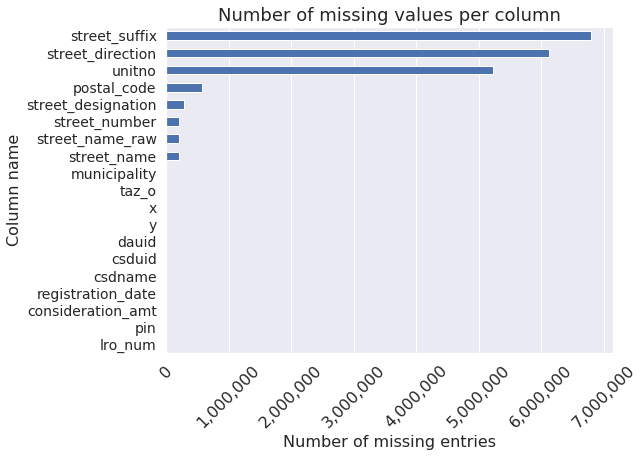

In [75]:
na_count = df.isnull().sum().sort_values()

f, ax = plt.subplots(1, figsize=(8, 6))
na_count.plot(kind='barh', ax=ax)
ax.grid(axis='y')
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=14)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title("Number of missing values per column", fontsize=18)
ax.set_ylabel("Column name", fontsize=16)
ax.set_xlabel("Number of missing entries", fontsize=16)
plt.savefig('results/teranet_na_count.png', dpi=400, bbox_inches='tight')

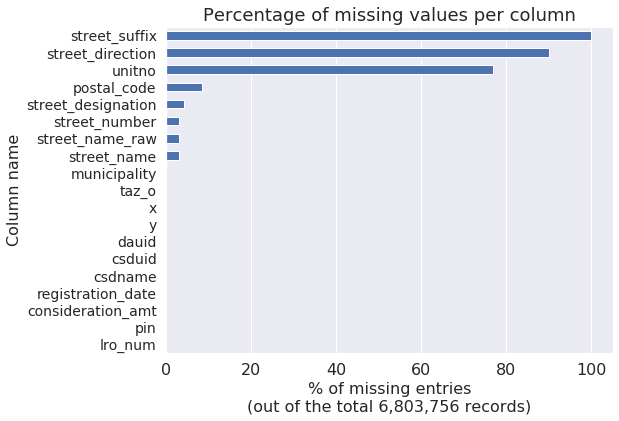

In [76]:
na_perc = df.isnull().sum().sort_values() / len(df) * 100

f, ax = plt.subplots(1, figsize=(8, 6))
na_perc.plot(kind='barh', ax=ax)
ax.grid(axis='y')
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title("Percentage of missing values per column", fontsize=18)
ax.set_ylabel("Column name", fontsize=16)
ax.set_xlabel("% of missing entries\n(out of the total {0:,} records)"
              .format(len(df)), fontsize=16)
plt.savefig('results/teranet_na_perc.png', dpi=400, bbox_inches='tight')

## Step 13: Remove column `street_suffix`
Since 99.99994% of the values in column `street_suffix` are missing, it has been removed from the dataset.

In [77]:
df = df.drop('street_suffix', axis=1)
print("Column 'street_suffix' was removed from the dataset.")

Column 'street_suffix' was removed from the dataset.


## Step 14: fix inconsistent values
Inconsistent entries are fixed in the following columns:
* Step 14.1: `street_direction`
* Step 14.2: `street_designaction`
* Step 14.3: `municipality`
* Step 14.4: `street_name`
* Step 14.5: `unitno`

### Step 14.1: Fix inconsistent values in column `street_direction`
Two Teranet records have `street_direction` = 'ES'. As it is unclear what should that correspond to (records correspond to the two transactions coming from some remote area north of Milton), their `street_direction` is reset to NaN (missing). Thus, `street_direction` for all Teranet records can be encoded as a singe character (catergory) that is either 'W', 'E', 'S', 'N', or NaN (missing).

In [78]:
df['street_direction'].value_counts()

W        316489
E        219818
N         70161
S         51637
West      11403
East       9193
North      2816
South      1607
N.          191
WEST        115
W.            6
E.            2
ES            2
NORTH         1
Name: street_direction, dtype: int64

#### Reset 'ES' to NaN

In [79]:
mask1 = df['street_direction'].str.match('ES', case=False, na=False)
df.loc[mask1, 'street_direction'].value_counts()

ES    2
Name: street_direction, dtype: int64

In [80]:
df.loc[mask1, 'street_direction'] = np.nan
df.loc[mask1, 'street_direction'].value_counts()

Series([], Name: street_direction, dtype: int64)

#### 'W'

In [81]:
mask1 = df['street_direction'].str.match('^W', case=False, na=False)
df.loc[mask1, 'street_direction'].value_counts()

W       316489
West     11403
WEST       115
W.           6
Name: street_direction, dtype: int64

In [82]:
df.loc[mask1, 'street_direction'] = 'W'
df.loc[mask1, 'street_direction'].value_counts()

W    328013
Name: street_direction, dtype: int64

#### 'E'

In [83]:
mask1 = df['street_direction'].str.match('^E', case=False, na=False)
df.loc[mask1, 'street_direction'].value_counts()

E       219818
East      9193
E.           2
Name: street_direction, dtype: int64

In [84]:
df.loc[mask1, 'street_direction'] = 'E'
df.loc[mask1, 'street_direction'].value_counts()

E    229013
Name: street_direction, dtype: int64

#### 'N'

In [85]:
mask1 = df['street_direction'].str.match('^N', case=False, na=False)
df.loc[mask1, 'street_direction'].value_counts()

N        70161
North     2816
N.         191
NORTH        1
Name: street_direction, dtype: int64

In [86]:
df.loc[mask1, 'street_direction'] = 'N'
df.loc[mask1, 'street_direction'].value_counts()

N    73169
Name: street_direction, dtype: int64

#### 'S'

In [87]:
mask1 = df['street_direction'].str.match('^S', case=False, na=False)
df.loc[mask1, 'street_direction'].value_counts()

S        51637
South     1607
Name: street_direction, dtype: int64

In [88]:
df.loc[mask1, 'street_direction'] = 'S'
df.loc[mask1, 'street_direction'].value_counts()

S    53244
Name: street_direction, dtype: int64

#### All inconsistent entries in column `street_direction` have been fixed.

In [89]:
df['street_direction'].value_counts()

W    328013
E    229013
N     73169
S     53244
Name: street_direction, dtype: int64

### Step 14.2: Fix inconsistent values in column `street_designation`
Street types were corrected in accordance with the [list of symbols and abbreviations](https://www.canadapost.ca/tools/pg/manual/PGaddress-e.asp?ecid=murl10006450) recognized by Canada Post. Only the values that needed correction are presented.

#### Abbey

In [90]:
mask1 = df['street_designation'].str.contains('Ab', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Abbey    11
Abe       4
Name: street_designation, dtype: int64

In [91]:
df.loc[mask1, 'street_designation'] = 'Abbey'
df.loc[mask1, 'street_designation'].value_counts()

Abbey    15
Name: street_designation, dtype: int64

#### Ave

In [92]:
mask1 = df['street_designation'].str.contains('Av', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Ave       1125986
Avenue      31482
Av           2061
Ave 5           2
Name: street_designation, dtype: int64

In [93]:
df.loc[mask1, 'street_designation'] = 'Ave'
df.loc[mask1, 'street_designation'].value_counts()

Ave    1159531
Name: street_designation, dtype: int64

#### Blvd

In [94]:
mask1 = df['street_designation'].str.contains('(bl|bo)', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


Blvd         325269
Boulevard     14041
Name: street_designation, dtype: int64

In [95]:
df.loc[mask1, 'street_designation'] = 'Blvd'
df.loc[mask1, 'street_designation'].value_counts()

Blvd    339310
Name: street_designation, dtype: int64

#### Cir

In [96]:
mask1 = df['street_designation'].str.contains('(cir$|circl)', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


Cir       133367
Circle      5616
Name: street_designation, dtype: int64

In [97]:
df.loc[mask1, 'street_designation'] = 'Cir'
df.loc[mask1, 'street_designation'].value_counts()

Cir    138983
Name: street_designation, dtype: int64

#### Crt

In [98]:
mask1 = df['street_designation'].str.contains('(Crt|Cou)', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


Crt      299387
Court     10876
Name: street_designation, dtype: int64

In [99]:
df.loc[mask1, 'street_designation'] = 'Crt'
df.loc[mask1, 'street_designation'].value_counts()

Crt    310263
Name: street_designation, dtype: int64

#### Cres

In [100]:
mask1 = df['street_designation'].str.contains('^Cre', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Cres        662213
Crescent     28068
Cresent         74
Name: street_designation, dtype: int64

In [101]:
df.loc[mask1, 'street_designation'] = 'Cres'
df.loc[mask1, 'street_designation'].value_counts()

Cres    690355
Name: street_designation, dtype: int64

#### Dell

In [102]:
mask1 = df['street_designation'].str.contains('^de', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Dell    19
De       2
Name: street_designation, dtype: int64

In [103]:
df.loc[mask1, 'street_designation'] = 'Dell'
df.loc[mask1, 'street_designation'].value_counts()

Dell    21
Name: street_designation, dtype: int64

#### Dr

In [104]:
mask1 = df['street_designation'].str.contains('Dr', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Dr          1076089
Drive         39475
Driveway       1997
Name: street_designation, dtype: int64

In [105]:
df.loc[mask1, 'street_designation'] = 'Dr'
df.loc[mask1, 'street_designation'].value_counts()

Dr    1117561
Name: street_designation, dtype: int64

#### Espl

In [106]:
mask1 = df['street_designation'].str.contains('^es', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Espl         8296
Esplanade    3487
Name: street_designation, dtype: int64

In [107]:
df.loc[mask1, 'street_designation'] = 'Espl'
df.loc[mask1, 'street_designation'].value_counts()

Espl    11783
Name: street_designation, dtype: int64

#### Landing

In [108]:
mask1 = df['street_designation'].str.contains('^land', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Landng     1272
Landing       2
Name: street_designation, dtype: int64

In [109]:
df.loc[mask1, 'street_designation'] = 'Landng'
df.loc[mask1, 'street_designation'].value_counts()

Landng    1274
Name: street_designation, dtype: int64

#### Lane

In [110]:
mask1 = df['street_designation'].str.contains('(lane|lanes|ln)', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


Lane     109029
Lanes        86
Ln           13
Name: street_designation, dtype: int64

In [111]:
df.loc[mask1, 'street_designation'] = 'Lane'
df.loc[mask1, 'street_designation'].value_counts()

Lane    109128
Name: street_designation, dtype: int64

#### Link

In [112]:
mask1 = df['street_designation'].str.contains('link', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Linkway    2458
Link         32
Name: street_designation, dtype: int64

In [113]:
df.loc[mask1, 'street_designation'] = 'Link'
df.loc[mask1, 'street_designation'].value_counts()

Link    2490
Name: street_designation, dtype: int64

#### Pky

In [114]:
mask1 = df['street_designation'].str.contains('(parkw|pky|pkwy)', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


Pky        20790
Pkwy           9
Parkway        8
Name: street_designation, dtype: int64

In [115]:
df.loc[mask1, 'street_designation'] = 'Pky'
df.loc[mask1, 'street_designation'].value_counts()

Pky    20807
Name: street_designation, dtype: int64

#### Pl

In [116]:
mask1 = df['street_designation'].str.contains('(^Pl$|Place)', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


Pl       117619
Place      2963
Name: street_designation, dtype: int64

In [117]:
df.loc[mask1, 'street_designation'] = 'Pl'
df.loc[mask1, 'street_designation'].value_counts()

Pl    120582
Name: street_designation, dtype: int64

#### Rd

In [118]:
mask1 = df['street_designation'].str.contains('(rd|roa)', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


Rd           884450
Road          48233
Sideroad       3685
Side rd        3118
Side road        83
Rd 30             5
Rd w              2
Name: street_designation, dtype: int64

In [119]:
df.loc[mask1, 'street_designation'] = 'Rd'
df.loc[mask1, 'street_designation'].value_counts()

Rd    939576
Name: street_designation, dtype: int64

#### St

In [120]:
mask1 = df['street_designation'].str.contains('^St', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

St        1018773
Street      47626
Name: street_designation, dtype: int64

In [121]:
df.loc[mask1, 'street_designation'] = 'St'
df.loc[mask1, 'street_designation'].value_counts()

St    1066399
Name: street_designation, dtype: int64

#### Sq

In [122]:
mask1 = df['street_designation'].str.contains('Sq', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Sq        47098
Square     1937
Name: street_designation, dtype: int64

In [123]:
df.loc[mask1, 'street_designation'] = 'Sq'
df.loc[mask1, 'street_designation'].value_counts()

Sq    49035
Name: street_designation, dtype: int64

#### Terr

In [124]:
mask1 = df['street_designation'].str.contains('Terr', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Terr       31332
Terrace     1147
Name: street_designation, dtype: int64

In [125]:
df.loc[mask1, 'street_designation'] = 'Terr'
df.loc[mask1, 'street_designation'].value_counts()

Terr    32479
Name: street_designation, dtype: int64

#### Terr

In [126]:
mask1 = df['street_designation'].str.contains('(Tra|Trl)', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


Trail    80732
Trl          4
Name: street_designation, dtype: int64

In [127]:
df.loc[mask1, 'street_designation'] = 'Trail'
df.loc[mask1, 'street_designation'].value_counts()

Trail    80736
Name: street_designation, dtype: int64

#### Vale

In [128]:
mask1 = df['street_designation'].str.contains('Val', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Vallee    105
Vale      101
Name: street_designation, dtype: int64

In [129]:
df.loc[mask1, 'street_designation'] = 'Vale'
df.loc[mask1, 'street_designation'].value_counts()

Vale    206
Name: street_designation, dtype: int64

#### Correct erratic entries: 48 refers to Highway 48

In [130]:
mask1 = df['street_designation'] == '48'
df[mask1]

,lro_num,pin,consideration_amt,registration_date,postal_code,unitno,street_name,street_designation,street_direction,municipality,street_number,x,y,dauid,csduid,csdname,taz_o,street_name_raw
706274,65,35430323,280000.0,2009-08-07,NaN,NaN,Highway,48,NaN,Georgina,27483,-79.304461,44.309741,35191146,3519070,Georgina,1348.0,Highway
706323,65,35430323,315000.0,2013-05-30,NaN,NaN,Highway,48,NaN,Georgina,27483,-79.304461,44.309741,35191146,3519070,Georgina,1348.0,Highway
706396,65,35430323,270000.0,2003-03-05,NaN,NaN,Highway,48,NaN,Georgina,27483,-79.304461,44.309741,35191146,3519070,Georgina,1348.0,Highway
706460,65,35430323,295000.0,2006-11-15,NaN,NaN,Highway,48,NaN,Georgina,27483,-79.304461,44.309741,35191146,3519070,Georgina,1348.0,Highway


In [131]:
df.loc[mask1, 'street_designation'] = 'Highway'
df.loc[mask1, 'street_name'] = 'Highway 48'
df.loc[mask1]

,lro_num,pin,consideration_amt,registration_date,postal_code,unitno,street_name,street_designation,street_direction,municipality,street_number,x,y,dauid,csduid,csdname,taz_o,street_name_raw
706274,65,35430323,280000.0,2009-08-07,NaN,NaN,Highway 48,Highway,NaN,Georgina,27483,-79.304461,44.309741,35191146,3519070,Georgina,1348.0,Highway
706323,65,35430323,315000.0,2013-05-30,NaN,NaN,Highway 48,Highway,NaN,Georgina,27483,-79.304461,44.309741,35191146,3519070,Georgina,1348.0,Highway
706396,65,35430323,270000.0,2003-03-05,NaN,NaN,Highway 48,Highway,NaN,Georgina,27483,-79.304461,44.309741,35191146,3519070,Georgina,1348.0,Highway
706460,65,35430323,295000.0,2006-11-15,NaN,NaN,Highway 48,Highway,NaN,Georgina,27483,-79.304461,44.309741,35191146,3519070,Georgina,1348.0,Highway


#### Correct erratic entries: Ctr refers to South Town Centre Blvd in Markham

In [132]:
mask1 = df['street_designation'].str.match('ctr', case=False, na=False)
df[mask1]

,lro_num,pin,consideration_amt,registration_date,postal_code,unitno,street_name,street_designation,street_direction,municipality,street_number,x,y,dauid,csduid,csdname,taz_o,street_name_raw
4940535,65,298440671,29000000.0,2007-12-18,NaN,611,South Town,Ctr,NaN,Markham,89,-79.336688,43.852045,35190747,3519036,Markham,1176.0,South Town
4940873,65,298440700,29000000.0,2007-12-18,NaN,901,South Town,Ctr,NaN,Markham,89,-79.336688,43.852045,35190747,3519036,Markham,1176.0,South Town
4941180,65,298440651,29000000.0,2007-12-18,NaN,901,South Town,Ctr,NaN,Markham,89,-79.336688,43.852045,35190747,3519036,Markham,1176.0,South Town
4941328,65,298440963,29000000.0,2007-12-18,NaN,107,South Town,Ctr,NaN,Markham,99,-79.336688,43.852045,35190747,3519036,Markham,1176.0,South Town
4947156,65,298440700,282320.0,2012-01-27,NaN,901,South Town,Ctr,NaN,Markham,89,-79.336688,43.852045,35190747,3519036,Markham,1176.0,South Town
4947446,65,298440671,282320.0,2012-01-27,NaN,611,South Town,Ctr,NaN,Markham,89,-79.336688,43.852045,35190747,3519036,Markham,1176.0,South Town
4947766,65,298440963,282320.0,2012-01-27,NaN,107,South Town,Ctr,NaN,Markham,99,-79.336688,43.852045,35190747,3519036,Markham,1176.0,South Town
4947996,65,298440651,282320.0,2012-01-27,NaN,901,South Town,Ctr,NaN,Markham,89,-79.336688,43.852045,35190747,3519036,Markham,1176.0,South Town
4948472,65,298440700,2.0,2012-06-01,NaN,901,South Town,Ctr,NaN,Markham,89,-79.336688,43.852045,35190747,3519036,Markham,1176.0,South Town
4948535,65,298440671,2.0,2012-06-01,NaN,611,South Town,Ctr,NaN,Markham,89,-79.336688,43.852045,35190747,3519036,Markham,1176.0,South Town


In [133]:
df.loc[mask1, 'street_designation'] = 'Blvd'
df.loc[mask1, 'street_name'] = 'South Town Centre'
df.loc[mask1]

,lro_num,pin,consideration_amt,registration_date,postal_code,unitno,street_name,street_designation,street_direction,municipality,street_number,x,y,dauid,csduid,csdname,taz_o,street_name_raw
4940535,65,298440671,29000000.0,2007-12-18,NaN,611,South Town Centre,Blvd,NaN,Markham,89,-79.336688,43.852045,35190747,3519036,Markham,1176.0,South Town
4940873,65,298440700,29000000.0,2007-12-18,NaN,901,South Town Centre,Blvd,NaN,Markham,89,-79.336688,43.852045,35190747,3519036,Markham,1176.0,South Town
4941180,65,298440651,29000000.0,2007-12-18,NaN,901,South Town Centre,Blvd,NaN,Markham,89,-79.336688,43.852045,35190747,3519036,Markham,1176.0,South Town
4941328,65,298440963,29000000.0,2007-12-18,NaN,107,South Town Centre,Blvd,NaN,Markham,99,-79.336688,43.852045,35190747,3519036,Markham,1176.0,South Town
4947156,65,298440700,282320.0,2012-01-27,NaN,901,South Town Centre,Blvd,NaN,Markham,89,-79.336688,43.852045,35190747,3519036,Markham,1176.0,South Town
4947446,65,298440671,282320.0,2012-01-27,NaN,611,South Town Centre,Blvd,NaN,Markham,89,-79.336688,43.852045,35190747,3519036,Markham,1176.0,South Town
4947766,65,298440963,282320.0,2012-01-27,NaN,107,South Town Centre,Blvd,NaN,Markham,99,-79.336688,43.852045,35190747,3519036,Markham,1176.0,South Town
4947996,65,298440651,282320.0,2012-01-27,NaN,901,South Town Centre,Blvd,NaN,Markham,89,-79.336688,43.852045,35190747,3519036,Markham,1176.0,South Town
4948472,65,298440700,2.0,2012-06-01,NaN,901,South Town Centre,Blvd,NaN,Markham,89,-79.336688,43.852045,35190747,3519036,Markham,1176.0,South Town
4948535,65,298440671,2.0,2012-06-01,NaN,611,South Town Centre,Blvd,NaN,Markham,89,-79.336688,43.852045,35190747,3519036,Markham,1176.0,South Town


#### All inconsistent entries in column `street_designation` have been fixed.

### Step 14.3: Fix inconsistent values in column `municipality`
`municipality` values were corrected in accordance with the 27 municipality names used for Dissemination Areas (DAs), as can be found in column `csdname` that was added to Teranet records via the spatial join performed during _Step 2.1_ of the cleanup process. Teranet records have a lot more different `municipality` names, such as 'York', 'East York', 'North York', 'Etobicoke', or smaller towns in GTHA, these values were left untouched; `municipality` names corresponding to major GTHA municipalities, that are used for DAs and can be found in column `csdname`, have been corrected to match the spelling found in Census datasets. 

In [134]:
df['csdname'].value_counts()

Toronto                          2785059
Mississauga                       703800
Brampton                          495970
Hamilton                          482691
Markham                           314783
Vaughan                           305212
Richmond Hill                     214837
Oakville                          210181
Burlington                        208953
Oshawa                            134040
Whitby                            110045
Milton                             94198
Ajax                               88102
Clarington                         86850
Caledon                            86725
Pickering                          86694
Newmarket                          73254
Halton Hills                       61429
Georgina                           59921
Aurora                             53802
Whitchurch-Stouffville             40728
King                               24894
Scugog                             23834
East Gwillimbury                   23568
Uxbridge        

### Toronto

In [135]:
mask1 = df['municipality'].str.contains('Toro', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

Toronto               1778555
North York/Toronto        168
City Of Toronto            57
Islington/Toronto           3
Name: municipality, dtype: int64

In [136]:
df.loc[mask1, 'municipality'] = 'Toronto'
df.loc[mask1, 'municipality'].value_counts()

Toronto    1778783
Name: municipality, dtype: int64

### Mississauga

In [137]:
mask1 = df['municipality'].str.contains('Mis', na=False, case=False)
mask2 = df['municipality'].str.contains('\sof\s', na=False, case=False)
df.loc[mask1 & ~mask2, 'municipality'].value_counts()

Mississauga     703496
Mississsauga         2
Name: municipality, dtype: int64

In [138]:
df.loc[mask1 & ~mask2, 'municipality'] = 'Mississauga'
df.loc[mask1 & ~mask2, 'municipality'].value_counts()

Mississauga    703498
Name: municipality, dtype: int64

### Hamilton

In [139]:
mask1 = df['municipality'].str.contains('hami', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

Hamilton            392133
Rural Hamilton        1214
City Of Hamilton       327
Hamilton City            2
Name: municipality, dtype: int64

In [140]:
df.loc[mask1, 'municipality'] = 'Hamilton'
df.loc[mask1, 'municipality'].value_counts()

Hamilton    393676
Name: municipality, dtype: int64

### Markham
#### Whit-Stouffville/Markham
Teranet records that have `municipality` value of 'Whit-Stouffville/Markham' are located in 'Whitchurch-Stouffville' according to their coordinates.

In [141]:
mask1 = df['municipality'] == 'Whit-Stouffville/Markham'
df.loc[mask1, ['municipality', 'csdname', 'y', 'x']]

,municipality,csdname,y,x
819531,Whit-Stouffville/Markham,Whitchurch-Stouffville,43.936371,-79.380210
820005,Whit-Stouffville/Markham,Whitchurch-Stouffville,43.936371,-79.380210
905590,Whit-Stouffville/Markham,Whitchurch-Stouffville,44.083982,-79.343559
1323339,Whit-Stouffville/Markham,Whitchurch-Stouffville,43.974472,-79.231358


In [142]:
df.loc[mask1, 'municipality'] = 'Whitchurch-Stouffville'
df.loc[mask1, 'municipality'].value_counts()

Whitchurch-Stouffville    4
Name: municipality, dtype: int64

#### Markham

In [143]:
mask1 = df['municipality'].str.contains('markh', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

Markham            258678
City Of Markham         6
Name: municipality, dtype: int64

In [144]:
df.loc[mask1, 'municipality'] = 'Markham'
df.loc[mask1, 'municipality'].value_counts()

Markham    258684
Name: municipality, dtype: int64

### Caledon

In [145]:
mask1 = df['municipality'].str.contains('(caledon$|caledon\s)', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


Caledon            80549
Caledon East         338
Caledon Village       38
East Caledon           2
Name: municipality, dtype: int64

In [146]:
df.loc[mask1, 'municipality'] = 'Caledon'
df.loc[mask1, 'municipality'].value_counts()

Caledon    80927
Name: municipality, dtype: int64

### Pickering

In [147]:
mask1 = df['municipality'].str.contains('pick', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

Pickering         86258
Pickering City        4
Name: municipality, dtype: int64

In [148]:
df.loc[mask1, 'municipality'] = 'Pickering'
df.loc[mask1, 'municipality'].value_counts()

Pickering    86262
Name: municipality, dtype: int64

### Newmarket

In [149]:
mask1 = df['municipality'].str.contains('newm', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

Newmarket             71923
Newmarket Township     2310
Name: municipality, dtype: int64

In [150]:
df.loc[mask1, 'municipality'] = 'Newmarket'
df.loc[mask1, 'municipality'].value_counts()

Newmarket    74233
Name: municipality, dtype: int64

### Halton Hills
`municipality` value 'Halton' seems to correspond to a number of municipalities (Milton, Oakville, Halton Hills), as indicated by correcsponding values of `csdname`, and is left unchanged.

In [151]:
mask1 = df['municipality'].str.contains('halton\s', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

Halton Hills    50528
Halton Hill         3
Name: municipality, dtype: int64

In [152]:
df.loc[mask1, 'municipality'] = 'Halton Hills'
df.loc[mask1, 'municipality'].value_counts()

Halton Hills    50531
Name: municipality, dtype: int64

### Georgina

In [153]:
mask1 = df['municipality'].str.contains('georgi', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

Georgina            35316
Town Of Georgina        9
Name: municipality, dtype: int64

In [154]:
df.loc[mask1, 'municipality'] = 'Georgina'
df.loc[mask1, 'municipality'].value_counts()

Georgina    35325
Name: municipality, dtype: int64

### Whitchurch-Stouffville

In [155]:
mask1 = df['municipality'].str.contains('(whitc|stou)', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


Whitchurch-Stouffville      20264
Stouffville                 16652
Whitchurch - Stouffville     2769
Whitchurch/Stouffville         23
Whitchurch                      2
Name: municipality, dtype: int64

In [156]:
df.loc[mask1, 'municipality'] = 'Whitchurch-Stouffville'
df.loc[mask1, 'municipality'].value_counts()

Whitchurch-Stouffville    39710
Name: municipality, dtype: int64

### King

In [157]:
mask1 = df['municipality'].str.contains('(king$|king\s)', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


King             10246
King City         6874
King Township     2699
Name: municipality, dtype: int64

In [158]:
df.loc[mask1, 'municipality'] = 'King'
df.loc[mask1, 'municipality'].value_counts()

King    19819
Name: municipality, dtype: int64

### Scugog

In [159]:
mask1 = df['municipality'].str.contains('scu', na=False, case=False)
mask2 = df['municipality'].str.contains('mississ', na=False, case=False)
df.loc[mask1 & ~mask2, 'municipality'].value_counts()

Scugog             16005
Scugog Township     2445
Name: municipality, dtype: int64

In [160]:
df.loc[mask1, 'municipality'] = 'Scugog'
df.loc[mask1, 'municipality'].value_counts()

Scugog    18456
Name: municipality, dtype: int64

### Uxbridge

In [161]:
mask1 = df['municipality'].str.contains('ux', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

Uxbridge             18704
Uxbridge Township     1641
Name: municipality, dtype: int64

In [162]:
df.loc[mask1, 'municipality'] = 'Uxbridge'
df.loc[mask1, 'municipality'].value_counts()

Uxbridge    20345
Name: municipality, dtype: int64

### Brock

In [163]:
mask1 = df['municipality'].str.contains('brock$|brock\s', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

Brock             7622
Brock Township    3953
Name: municipality, dtype: int64

In [164]:
df.loc[mask1, 'municipality'] = 'Brock'
df.loc[mask1, 'municipality'].value_counts()

Brock    11575
Name: municipality, dtype: int64

### Step 14.4: Inconsistent values in column `street_name`
Consistency of entries in column `street_name` was improved through parsing out zip codes, unit and street numbers, street directions and street designations in the previous steps. Corrections for most frequently encountered street names are made in this subsection.

In [165]:
df['street_name'].value_counts()

Yonge                            82528
King                             46727
Sheppard                         36154
Bay                              35939
Lakeshore                        32420
Eglinton                         29127
Queens                           27818
Bloor                            26064
Lake Shore                       24647
Bayview                          22205
Dundas                           21262
Harrison Garden                  20746
Queen                            20236
Hillcrest                        18882
Front                            18832
Bamburgh                         17666
Lee Centre                       17505
Kingsbridge Garden               17440
Finch                            17366
Webb                             16792
Richmond                         16786
Bathurst                         16716
Mill                             16597
Main                             16446
Burnhamthorpe                    16009
Steeles                  

#### Yonge St

In [166]:
mask1 = df['street_name'].str.contains('yonge\ss', na=False, case=False)
mask2 = df['street_name'].str.contains('(,|Tower|\/)', na=False, case=False)
df.loc[mask1 & ~mask2, 'street_name'].value_counts()

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


Yonge Street                       89
Yonge Steet                         6
Yonge Street South Of Ravenshoe     5
Yonge Stree                         5
Yonge Street Ric                    2
Yonge Strret                        1
Yonge Steeet                        1
Yonge Sstreet                       1
Name: street_name, dtype: int64

In [167]:
df.loc[mask1 & ~mask2, 'street_name'] = 'Yonge'
df.loc[mask1 & ~mask2, 'street_designation'] = 'St'
df.loc[mask1 & ~mask2, 'street_name'].value_counts()

Yonge    110
Name: street_name, dtype: int64

#### King St

In [168]:
mask1 = df['street_name'].str.contains('king\sstreet$|king\sst$|king\sst\.|king\sstreet,$', na=False, case=False)
df.loc[mask1, 'street_name'].value_counts()

King Street     40
King St          8
King St.         3
King Street,     2
Name: street_name, dtype: int64

In [169]:
df.loc[mask1, 'street_name'] = 'King'
df.loc[mask1, 'street_designation'] = 'St'
df.loc[mask1, 'street_name'].value_counts()

King    53
Name: street_name, dtype: int64

#### Sheppard Ave

##### Fix street directions

In [170]:
mask1 = df['street_name'] == "Sheppard AveE."
df.loc[mask1, ['unitno', 'street_number', 'street_name', 'street_direction', 'municipality', 'y', 'x']]

,unitno,street_number,street_name,street_direction,municipality,y,x
536458,NaN,200,Sheppard AveE.,NaN,Willowdale,43.763833,-79.401759
536459,NaN,200,Sheppard AveE.,NaN,Willowdale,43.763833,-79.401759
536467,NaN,200,Sheppard AveE.,NaN,Willowdale,43.763833,-79.401759
536486,NaN,222,Sheppard AveE.,NaN,Willowdale,43.764049,-79.400651
536518,NaN,218,Sheppard AveE.,NaN,Willowdale,43.763952,-79.401102
536688,NaN,218,Sheppard AveE.,NaN,Willowdale,43.763952,-79.401102
536778,NaN,222,Sheppard AveE.,NaN,Willowdale,43.764049,-79.400651
536919,NaN,200,Sheppard AveE.,NaN,Willowdale,43.763833,-79.401759
536929,NaN,218,Sheppard AveE.,NaN,Willowdale,43.763952,-79.401102
813468,NaN,166,Sheppard AveE.,NaN,Willowdale,43.764131,-79.404090


In [171]:
df.loc[mask1, 'street_direction'] = 'E'
df.loc[mask1, ['unitno', 'street_number', 'street_name', 'street_direction', 'municipality', 'y', 'x']]

,unitno,street_number,street_name,street_direction,municipality,y,x
536458,NaN,200,Sheppard AveE.,E,Willowdale,43.763833,-79.401759
536459,NaN,200,Sheppard AveE.,E,Willowdale,43.763833,-79.401759
536467,NaN,200,Sheppard AveE.,E,Willowdale,43.763833,-79.401759
536486,NaN,222,Sheppard AveE.,E,Willowdale,43.764049,-79.400651
536518,NaN,218,Sheppard AveE.,E,Willowdale,43.763952,-79.401102
536688,NaN,218,Sheppard AveE.,E,Willowdale,43.763952,-79.401102
536778,NaN,222,Sheppard AveE.,E,Willowdale,43.764049,-79.400651
536919,NaN,200,Sheppard AveE.,E,Willowdale,43.763833,-79.401759
536929,NaN,218,Sheppard AveE.,E,Willowdale,43.763952,-79.401102
813468,NaN,166,Sheppard AveE.,E,Willowdale,43.764131,-79.404090


In [172]:
mask1 = df['street_name'] == "Sheppard AveW."
df.loc[mask1, ['unitno', 'street_number', 'street_name', 'street_direction', 'municipality', 'y', 'x']]

,unitno,street_number,street_name,street_direction,municipality,y,x
1652625,NaN,115,Sheppard AveW.,NaN,North York,43.759937,-79.416730
1652838,NaN,133,Sheppard AveW.,NaN,Willowdale,43.759736,-79.417652
1652892,NaN,137,Sheppard AveW.,NaN,North York,43.759712,-79.417744
1652895,NaN,115,Sheppard AveW.,NaN,North York,43.759937,-79.416730
1652911,NaN,109,Sheppard AveW.,NaN,North York,43.760000,-79.416439


In [173]:
df.loc[mask1, 'street_direction'] = 'W'
df.loc[mask1, ['unitno', 'street_number', 'street_name', 'street_direction', 'municipality', 'y', 'x']]

,unitno,street_number,street_name,street_direction,municipality,y,x
1652625,NaN,115,Sheppard AveW.,W,North York,43.759937,-79.416730
1652838,NaN,133,Sheppard AveW.,W,Willowdale,43.759736,-79.417652
1652892,NaN,137,Sheppard AveW.,W,North York,43.759712,-79.417744
1652895,NaN,115,Sheppard AveW.,W,North York,43.759937,-79.416730
1652911,NaN,109,Sheppard AveW.,W,North York,43.760000,-79.416439


##### Fix street name and street designation

In [174]:
mask1 = df['street_name'].str.contains('sheppard av', na=False, case=False)
mask2 = df['street_name'].str.contains('\(', na=False, case=False)
df.loc[mask1 & ~mask2, 'street_name'].value_counts()

Sheppard Avenue    91
Sheppard AveE.     13
Sheppard Ave        7
Sheppard AveW.      5
Name: street_name, dtype: int64

In [175]:
df.loc[mask1, 'street_name'] = 'Sheppard'
df.loc[mask1, 'street_designation'] = 'Ave'
df.loc[mask1, 'street_name'].value_counts()

Sheppard    119
Name: street_name, dtype: int64

#### Bloor St

##### Fix street number

In [176]:
mask1 = df['street_name'].str.contains('^bloor\ss', na=False, case=False)
mask2 = df['street_name'].str.contains('\se', na=False, case=False)
mask3 = df['street_name'].str.contains('#', na=False)
df.loc[mask1 & mask2 & mask3, 'street_name'].value_counts()

Bloor Street East, #807    1
Name: street_name, dtype: int64

In [177]:
df.loc[mask1 & mask2 & mask3, 'street_number'] = 807
print("Street number fixed!")

Street number fixed!


##### Fix street direction

In [178]:
mask1 = df['street_name'].str.contains('^bloor\ss', na=False, case=False)
mask2 = df['street_name'].str.contains('\se', na=False, case=False)
df.loc[mask1 & mask2, 'street_name'].value_counts()

Bloor St Est               2
Bloor Street East, #807    1
Bloor Street Est           1
Bloor Street East`         1
Name: street_name, dtype: int64

In [179]:
df.loc[mask1 & mask2, 'street_direction'] = 'E'
print("Street direction fixed!")

Street direction fixed!


##### Fix street name and street designation

In [180]:
mask1 = df['street_name'].str.contains('^bloor\ss', na=False, case=False)
df.loc[mask1, 'street_name'].value_counts()

Bloor Streest              3
Bloor Sreet                2
Bloor Stree                2
Bloor St Est               2
Bloor Street East, #807    1
Bloor Streeat              1
Bloor Street,              1
Bloor Street East`         1
Bloor Strret               1
Bloor Street Est           1
Name: street_name, dtype: int64

In [181]:
df.loc[mask1, 'street_name'] = 'Bloor'
df.loc[mask1, 'street_designation'] = 'St'
df.loc[mask1, 'street_name'].value_counts()

Bloor    15
Name: street_name, dtype: int64

#### Dundas St

In [182]:
mask1 = df['street_name'].str.contains('^Dundas\ss$|^dundas\sst', na=False, case=False)
df.loc[mask1, 'street_name'].value_counts()

Dundas Street        21
Dundas St.            3
Dundas Street,        2
Dundas S              1
Dundas St             1
Dundas St E Hwy 5     1
Name: street_name, dtype: int64

In [183]:
df.loc[mask1, 'street_name'] = 'Dundas'
df.loc[mask1, 'street_designation'] = 'St'
df.loc[mask1, 'street_name'].value_counts()

Dundas    29
Name: street_name, dtype: int64

#### Front St

In [184]:
mask1 = df['street_name'].str.contains('Front\s', na=False, case=False)
df.loc[mask1, 'street_name'].value_counts()

Front Street,    1
Front Stree      1
Front Stereet    1
Name: street_name, dtype: int64

In [185]:
df.loc[mask1, 'street_name'] = 'Front'
df.loc[mask1, 'street_designation'] = 'St'
df.loc[mask1, 'street_name'].value_counts()

Front    3
Name: street_name, dtype: int64

There are many more inconsistencies present in column `street_name`, but since fixing all of them presents a time-intensive task, it is left until a future stage when targeted corrections can be performed where required.

### Step 14.5: Fix values in column `unitno`

#### 1.010000e-107

In [186]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('1.01')
mask3 = unit_no.str.match('1.009')
df.loc[mask1 & (mask2 | mask3), 'unitno']

340623    1.01e-107
Name: unitno, dtype: object

In [187]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 101
df.loc[mask1 & (mask2 | mask3), 'unitno']

340623    101
Name: unitno, dtype: object

#### 1.200000e-/+x
>It is impossible to tell, if this erratic unit number corresponds to '12', '120', or '1200'. All units that match this pattern have been converted to '12'.

In [188]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('1.199')
df.loc[mask1 & mask2, 'unitno']

3953650    1.2e-103
3953713    1.2e-200
3953736    1.2e-200
3953804    1.2e-200
3953838    1.2e-200
3954492    1.2e-200
3954599    1.2e-200
3954662    1.2e-200
3954695    1.2e-200
3954698    1.2e-103
3954741    1.2e-200
3954742    1.2e-200
3954744    1.2e-200
3954745    1.2e-200
3954818    1.2e-103
3955297    1.2e-103
Name: unitno, dtype: object

In [189]:
df.loc[mask1 & mask2, 'unitno'] = 12
df.loc[mask1 & mask2, 'unitno']

3953650    12
3953713    12
3953736    12
3953804    12
3953838    12
3954492    12
3954599    12
3954662    12
3954695    12
3954698    12
3954741    12
3954742    12
3954744    12
3954745    12
3954818    12
3955297    12
Name: unitno, dtype: object

#### 2.000000e-/+x
>It is impossible to tell, if this erratic unit number corresponds to '2', '20', or '200'. All units that match this pattern have been converted to '2'.

In [190]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('2')
mask3 = unit_no.str.match('1.99')
df.loc[mask1 & (mask2 | mask3), 'unitno']

803806      2e-22
804396      2e-22
804402      2e-22
976907     2e+105
980160     2e+155
980191     2e+155
985947     2e+105
1319485     2e-06
1319632     2e-05
1320027     2e-06
1745160     2e+18
1745161     2e+19
1745162     2e+21
1746287     2e+18
1746288     2e+19
1746289     2e+21
2898124    2e-123
2901826    2e-123
2902716    2e-123
4334143     2e-12
4334293     2e-12
4334368     2e-12
Name: unitno, dtype: object

In [191]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 2
df.loc[mask1 & (mask2 | mask3), 'unitno']

803806     2
804396     2
804402     2
976907     2
980160     2
980191     2
985947     2
1319485    2
1319632    2
1320027    2
1745160    2
1745161    2
1745162    2
1746287    2
1746288    2
1746289    2
2898124    2
2901826    2
2902716    2
4334143    2
4334293    2
4334368    2
Name: unitno, dtype: object

#### 1.100000e-201
>It is impossible to tell, if this erratic unit number corresponds to '11', '110', or '1100'. All units that match this pattern have been converted to '11'.

In [192]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('1.1')
mask3 = unit_no.str.match('1.09')
df.loc[mask1 & (mask2 | mask3), 'unitno']

3953672    1.1e-201
3953690    1.1e-201
3953730    1.1e-201
3954525    1.1e-201
3954543    1.1e-201
3954574    1.1e-201
3954834    1.1e-201
3954835    1.1e-201
3954836    1.1e-201
3955457    1.1e-201
3955459    1.1e-201
3955460    1.1e-201
Name: unitno, dtype: object

In [193]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 11
df.loc[mask1 & (mask2 | mask3), 'unitno']

3953672    11
3953690    11
3953730    11
3954525    11
3954543    11
3954574    11
3954834    11
3954835    11
3954836    11
3955457    11
3955459    11
3955460    11
Name: unitno, dtype: object

#### 1.700000e-06
>It is impossible to tell, if this erratic unit number corresponds to '17', '170', or '1700'. All units that match this pattern have been converted to '17'.

In [194]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('1.7')
mask3 = unit_no.str.match('1.69')
df.loc[mask1 & (mask2 | mask3), 'unitno']

1288121    1.7e-06
1288489    1.7e-06
Name: unitno, dtype: object

In [195]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 17
df.loc[mask1 & (mask2 | mask3), 'unitno']

1288121    17
1288489    17
Name: unitno, dtype: object

#### 1.800000e-19
>It is impossible to tell, if this erratic unit number corresponds to '18', '180', or '1800'. All units that match this pattern have been converted to '18'.

In [196]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('1.8')
mask3 = unit_no.str.match('1.79')
df.loc[mask1 & (mask2 | mask3), 'unitno']

4939911    1.8e-19
Name: unitno, dtype: object

In [197]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 18
df.loc[mask1 & (mask2 | mask3), 'unitno']

4939911    18
Name: unitno, dtype: object

#### 3.300000e-33
>It is impossible to tell, if this erratic unit number corresponds to '33', '330', or '3300'. All units that match this pattern have been converted to '33'.

In [198]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('3.3')
mask3 = unit_no.str.match('3.29')
df.loc[mask1 & (mask2 | mask3), 'unitno']

410174    3.3e-33
410504    3.3e-33
410511    3.3e-33
Name: unitno, dtype: object

In [199]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 33
df.loc[mask1 & (mask2 | mask3), 'unitno']

410174    33
410504    33
410511    33
Name: unitno, dtype: object

#### 6.000000e-x
>It is impossible to tell, if this erratic unit number corresponds to '6', '60', or '600'. All units that match this pattern have been converted to '6'.

In [200]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('6')
mask3 = unit_no.str.match('5.9')
df.loc[mask1 & (mask2 | mask3), 'unitno']

2900974     6e-22
2902616     6e-22
3953674    6e-104
3953678    6e-104
3953738    6e-201
3953767    6e-201
3953778    6e-201
3953786    6e-201
3953834    6e-201
3954467    6e-201
3954491    6e-201
3954532    6e-201
3954552    6e-201
3954579    6e-104
3954672    6e-201
3954688    6e-104
3954722    6e-104
3954724    6e-104
3954779    6e-201
3954780    6e-201
3954781    6e-201
3954782    6e-201
3954783    6e-201
3955495    6e-104
3955497    6e-104
Name: unitno, dtype: object

In [201]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 6
df.loc[mask1 & (mask2 | mask3), 'unitno']

2900974    6
2902616    6
3953674    6
3953678    6
3953738    6
3953767    6
3953778    6
3953786    6
3953834    6
3954467    6
3954491    6
3954532    6
3954552    6
3954579    6
3954672    6
3954688    6
3954722    6
3954724    6
3954779    6
3954780    6
3954781    6
3954782    6
3954783    6
3955495    6
3955497    6
Name: unitno, dtype: object

#### 5.000000e-x
>It is impossible to tell, if this erratic unit number corresponds to '5', '50', or '500'. All units that match this pattern have been converted to '5'.

In [202]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('5')
mask3 = unit_no.str.match('4.9')
df.loc[mask1 & (mask2 | mask3), 'unitno']

3953645    5e-103
3953721    5e-102
3953744    5e-103
3953840    5e-102
3954521    5e-103
3954541    5e-103
3954607    5e-102
3954693    5e-102
3954812    5e-102
3954814    5e-102
3954884    5e-103
3954885    5e-103
4287864     5e-06
4287865     5e-06
Name: unitno, dtype: object

In [203]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 5
df.loc[mask1 & (mask2 | mask3), 'unitno']

3953645    5
3953721    5
3953744    5
3953840    5
3954521    5
3954541    5
3954607    5
3954693    5
3954812    5
3954814    5
3954884    5
3954885    5
4287864    5
4287865    5
Name: unitno, dtype: object

#### 1.000000e-/+21
>It is impossible to tell, if this erratic unit number corresponds to '1', '10', or '100'. All units that match this pattern have been converted to '1'.

In [204]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('1')
mask3 = unit_no.str.match('0.9')
id_list = [3953792, 3954603, 3954834]
mask4 = unit_no.index.isin(id_list)
df.loc[mask1 & (mask2 | mask3) | mask4, 'unitno']

1745104    1e+21
1745164    1e+18
1745165    1e+20
1745166    1e+22
1745167    1e+25
1745168    1e+27
1745171    1e+19
1745172    1e+17
1745173    1e+21
1745187    1e+26
1745189    1e+23
1745212    1e+17
1745221    1e+16
1745347    1e+19
1745463    1e+17
1745464    1e+19
1745465    1e+21
1745466    1e+23
1745554    1e+26
1745693    1e+26
1746243    1e+20
1746244    1e+27
1746245    1e+22
1746246    1e+25
1746247    1e+18
1746467    1e+17
2908785    1e-10
2908853    1e-10
2908989    1e-10
2909130    1e-10
3822327    1e-05
3822328    1e-05
3822329    1e-05
3822330    1e-05
3822331    1e-05
3953792      NaN
3954603      102
3954834       11
4989671    1e-20
4989673    1e-20
4989698    1e-20
Name: unitno, dtype: object

In [205]:
df.loc[mask1 & (mask2 | mask3) | mask4, 'unitno'] = 1
df.loc[mask1 & (mask2 | mask3) | mask4, 'unitno']

1745104    1
1745164    1
1745165    1
1745166    1
1745167    1
1745168    1
1745171    1
1745172    1
1745173    1
1745187    1
1745189    1
1745212    1
1745221    1
1745347    1
1745463    1
1745464    1
1745465    1
1745466    1
1745554    1
1745693    1
1746243    1
1746244    1
1746245    1
1746246    1
1746247    1
1746467    1
2908785    1
2908853    1
2908989    1
2909130    1
3822327    1
3822328    1
3822329    1
3822330    1
3822331    1
3953792    1
3954603    1
3954834    1
4989671    1
4989673    1
4989698    1
Name: unitno, dtype: object

#### 9.000000e-104
>It is impossible to tell, if this erratic unit number corresponds to '9', '90', or '900'. All units that match this pattern have been converted to '9'.

In [206]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('9')
mask3 = unit_no.str.match('8.9')
df.loc[mask1 & (mask2 | mask3), 'unitno']

3953846    9e-104
3953854    1e-101
3954665    1e-101
3954671    9e-104
3954830    9e-104
3954896    1e-101
3955017    9e-104
3955104    9e-104
3956148    9e-104
3956601    9e-104
Name: unitno, dtype: object

In [207]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 9
df.loc[mask1 & (mask2 | mask3), 'unitno']

3953846    9
3953854    9
3954665    9
3954671    9
3954830    9
3954896    9
3955017    9
3955104    9
3956148    9
3956601    9
Name: unitno, dtype: object

#### 4.000000e-104
>It is impossible to tell, if this erratic unit number corresponds to '4', '40', or '400'. All units that match this pattern have been converted to '4'.

In [208]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('4')
mask3 = unit_no.str.match('3.9')
df.loc[mask1 & (mask2 | mask3), 'unitno']

3953775    4e-104
3954686    4e-104
3954816    4e-104
3956044    4e-104
Name: unitno, dtype: object

In [209]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 4
df.loc[mask1 & (mask2 | mask3), 'unitno']

3953775    4
3954686    4
3954816    4
3956044    4
Name: unitno, dtype: object

#### 0.01

In [210]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0\.01')
df.loc[mask1, 'unitno']

15869    0.01
79214    0.01
79406    0.01
79471    0.01
80113    0.01
Name: unitno, dtype: object

In [211]:
df.loc[mask1, 'unitno'] = 1
df.loc[mask1, 'unitno']

15869    1
79214    1
79406    1
79471    1
80113    1
Name: unitno, dtype: object

#### 0.37

In [212]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0\.37')
df.loc[mask1, 'unitno']

836960    0.37
839746    0.37
851331    0.37
859839    0.37
865498    0.37
Name: unitno, dtype: object

In [213]:
df.loc[mask1, 'unitno'] = 37
df.loc[mask1, 'unitno']

836960    37
839746    37
851331    37
859839    37
865498    37
Name: unitno, dtype: object

#### 0.000815

In [214]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0\.000815')
df.loc[mask1, 'unitno']

4449822    0.000815
4449823    0.000815
4451657    0.000815
4451658    0.000815
Name: unitno, dtype: object

In [215]:
df.loc[mask1, 'unitno'] = 815
df.loc[mask1, 'unitno']

4449822    815
4449823    815
4451657    815
4451658    815
Name: unitno, dtype: object

#### 0.033

In [216]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0\.033')
df.loc[mask1, 'unitno']

853105    0.033
Name: unitno, dtype: object

In [217]:
df.loc[mask1, 'unitno'] = 33
df.loc[mask1, 'unitno']

853105    33
Name: unitno, dtype: object

#### 0.24

In [218]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0\.24')
df.loc[mask1, 'unitno']

3419854    0.24
3420076    0.24
3420342    0.24
3420559    0.24
Name: unitno, dtype: object

In [219]:
df.loc[mask1, 'unitno'] = 24
df.loc[mask1, 'unitno']

3419854    24
3420076    24
3420342    24
3420559    24
Name: unitno, dtype: object

#### 0.2

In [220]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0\.2')
df.loc[mask1, 'unitno']

1319366    0.2
3234588    0.2
3234666    0.2
3234743    0.2
4334017    0.2
4334039    0.2
4334106    0.2
4334108    0.2
4334110    0.2
4334113    0.2
4334157    0.2
4334194    0.2
4334213    0.2
4334253    0.2
4334255    0.2
4334264    0.2
4334369    0.2
4334388    0.2
4334421    0.2
4334422    0.2
4334423    0.2
4334428    0.2
4334461    0.2
Name: unitno, dtype: object

In [221]:
df.loc[mask1, 'unitno'] = 2
df.loc[mask1, 'unitno']

1319366    2
3234588    2
3234666    2
3234743    2
4334017    2
4334039    2
4334106    2
4334108    2
4334110    2
4334113    2
4334157    2
4334194    2
4334213    2
4334253    2
4334255    2
4334264    2
4334369    2
4334388    2
4334421    2
4334422    2
4334423    2
4334428    2
4334461    2
Name: unitno, dtype: object

#### 0.003

In [222]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0\.003')
df.loc[mask1, 'unitno']

4334098    0.003
4334121    0.003
4334172    0.003
4334193    0.003
4334234    0.003
4334275    0.003
4334378    0.003
4334389    0.003
4334405    0.003
Name: unitno, dtype: object

In [223]:
df.loc[mask1, 'unitno'] = 3
df.loc[mask1, 'unitno']

4334098    3
4334121    3
4334172    3
4334193    3
4334234    3
4334275    3
4334378    3
4334389    3
4334405    3
Name: unitno, dtype: object

#### 0.04

In [224]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0\.04')
df.loc[mask1, 'unitno']

4334177    0.04
4334365    0.04
Name: unitno, dtype: object

In [225]:
df.loc[mask1, 'unitno'] = 4
df.loc[mask1, 'unitno']

4334177    4
4334365    4
Name: unitno, dtype: object

#### 0.001

In [226]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0\.001')
df.loc[mask1, 'unitno']

2611713    0.001
2612463    0.001
2612464    0.001
2612468    0.001
2612798    0.001
2612799    0.001
2612800    0.001
Name: unitno, dtype: object

In [227]:
df.loc[mask1, 'unitno'] = 1
df.loc[mask1, 'unitno']

2611713    1
2612463    1
2612464    1
2612468    1
2612798    1
2612799    1
2612800    1
Name: unitno, dtype: object

#### 0.0026

In [228]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0\.0026')
df.loc[mask1, 'unitno']

2898705    0.0026
2900804    0.0026
2902399    0.0026
Name: unitno, dtype: object

In [229]:
df.loc[mask1, 'unitno'] = 26
df.loc[mask1, 'unitno']

2898705    26
2900804    26
2902399    26
Name: unitno, dtype: object

#### 0.0024

In [230]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0\.0024')
df.loc[mask1, 'unitno']

1288123    0.0024
1288490    0.0024
Name: unitno, dtype: object

In [231]:
df.loc[mask1, 'unitno'] = 24
df.loc[mask1, 'unitno']

1288123    24
1288490    24
Name: unitno, dtype: object

#### 0.66

In [232]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0\.66')
df.loc[mask1, 'unitno']

3861776    0.66
3862100    0.66
3862323    0.66
3868588    0.66
3870397    0.66
Name: unitno, dtype: object

In [233]:
df.loc[mask1, 'unitno'] = 66
df.loc[mask1, 'unitno']

3861776    66
3862100    66
3862323    66
3868588    66
3870397    66
Name: unitno, dtype: object

#### 0.83

In [234]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0\.83')
df.loc[mask1, 'unitno']

1067348    0.83
1067892    0.83
1069048    0.83
Name: unitno, dtype: object

In [235]:
df.loc[mask1, 'unitno'] = 83
df.loc[mask1, 'unitno']

1067348    83
1067892    83
1069048    83
Name: unitno, dtype: object

#### 3.01

In [236]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^3\.01$')
df.loc[mask1, 'unitno']

1927321    3.01
1927322    3.01
1927323    3.01
1927324    3.01
1927389    3.01
1927390    3.01
1927391    3.01
1927392    3.01
Name: unitno, dtype: object

In [237]:
df.loc[mask1, 'unitno'] = 301
df.loc[mask1, 'unitno']

1927321    301
1927322    301
1927323    301
1927324    301
1927389    301
1927390    301
1927391    301
1927392    301
Name: unitno, dtype: object

#### 1.5

In [238]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^1.5$')
df.loc[mask1, 'unitno']

801973    1.5
803272    1.5
Name: unitno, dtype: object

In [239]:
df.loc[mask1, 'unitno'] = 15
df.loc[mask1, 'unitno']

801973    15
803272    15
Name: unitno, dtype: object

#### 1.6

In [240]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^1\.6$')
df.loc[mask1, 'unitno']

801974    1.6
803275    1.6
Name: unitno, dtype: object

In [241]:
df.loc[mask1, 'unitno'] = 16
df.loc[mask1, 'unitno']

801974    16
803275    16
Name: unitno, dtype: object

#### 4.2

In [242]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^4\.2$')
df.loc[mask1, 'unitno']

6239693    4.2
6244176    4.2
Name: unitno, dtype: object

In [243]:
df.loc[mask1, 'unitno'] = 42
df.loc[mask1, 'unitno']

6239693    42
6244176    42
Name: unitno, dtype: object

#### 7.9

In [244]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^7\.9$')
df.loc[mask1, 'unitno']

2994515    7.9
2996017    7.9
Name: unitno, dtype: object

In [245]:
df.loc[mask1, 'unitno'] = 79
df.loc[mask1, 'unitno']

2994515    79
2996017    79
Name: unitno, dtype: object

#### 1.9

In [246]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^1\.9$')
df.loc[mask1, 'unitno']

2734929    1.9
2735344    1.9
2735651    1.9
Name: unitno, dtype: object

In [247]:
df.loc[mask1, 'unitno'] = 19
df.loc[mask1, 'unitno']

2734929    19
2735344    19
2735651    19
Name: unitno, dtype: object

#### 9.5

In [248]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^9\.5$')
df.loc[mask1, 'unitno']

2672388    9.5
2673429    9.5
2675604    9.5
2675606    9.5
Name: unitno, dtype: object

In [249]:
df.loc[mask1, 'unitno'] = 95
df.loc[mask1, 'unitno']

2672388    95
2673429    95
2675604    95
2675606    95
Name: unitno, dtype: object

#### 0.02, 0.002, and 0.0002

In [250]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^0')
mask2 = unit_no.str.contains('2')
df.loc[mask1 & mask2, 'unitno']

1319376     0.002
1319570      0.02
1319618    0.0002
1320414      0.02
Name: unitno, dtype: object

In [251]:
df.loc[mask1 & mask2, 'unitno'] = 2
df.loc[mask1 & mask2, 'unitno']

1319376    2
1319570    2
1319618    2
1320414    2
Name: unitno, dtype: object

#### 4.7

In [252]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^4\.7$')
df.loc[mask1, 'unitno']

853106    4.7
Name: unitno, dtype: object

In [253]:
df.loc[mask1, 'unitno'] = 47
df.loc[mask1, 'unitno']

853106    47
Name: unitno, dtype: object

#### 6.5

In [254]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^6\.5$')
df.loc[mask1, 'unitno']

1963017    6.5
Name: unitno, dtype: object

In [255]:
df.loc[mask1, 'unitno'] = 65
df.loc[mask1, 'unitno']

1963017    65
Name: unitno, dtype: object

#### 3.5

In [256]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^3\.5$')
df.loc[mask1, 'unitno']

1963021    3.5
Name: unitno, dtype: object

In [257]:
df.loc[mask1, 'unitno'] = 35
df.loc[mask1, 'unitno']

1963021    35
Name: unitno, dtype: object

#### 16.9

In [258]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^16\.9$')
df.loc[mask1, 'unitno']

1963041    16.9
1963109    16.9
1964176    16.9
Name: unitno, dtype: object

In [259]:
df.loc[mask1, 'unitno'] = 169
df.loc[mask1, 'unitno']

1963041    169
1963109    169
1964176    169
Name: unitno, dtype: object

#### 10.4

In [260]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^10\.4$')
df.loc[mask1, 'unitno']

1963078    10.4
1964047    10.4
Name: unitno, dtype: object

In [261]:
df.loc[mask1, 'unitno'] = 104
df.loc[mask1, 'unitno']

1963078    104
1964047    104
Name: unitno, dtype: object

#### 17.2

In [262]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^17\.2$')
df.loc[mask1, 'unitno']

1963155    17.2
1964298    17.2
Name: unitno, dtype: object

In [263]:
df.loc[mask1, 'unitno'] = 172
df.loc[mask1, 'unitno']

1963155    172
1964298    172
Name: unitno, dtype: object

#### 16.2

In [264]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^16\.2$')
df.loc[mask1, 'unitno']

1964907    16.2
Name: unitno, dtype: object

In [265]:
df.loc[mask1, 'unitno'] = 162
df.loc[mask1, 'unitno']

1964907    162
Name: unitno, dtype: object

#### 16.1

In [266]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^16\.1$')
df.loc[mask1, 'unitno']

1964971    16.1
Name: unitno, dtype: object

In [267]:
df.loc[mask1, 'unitno'] = 161
df.loc[mask1, 'unitno']

1964971    161
Name: unitno, dtype: object

#### 16.5

In [268]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^16\.5$')
df.loc[mask1, 'unitno']

1964977    16.5
Name: unitno, dtype: object

In [269]:
df.loc[mask1, 'unitno'] = 165
df.loc[mask1, 'unitno']

1964977    165
Name: unitno, dtype: object

#### All erratic values in column `unitno` have been fixed

## Save results to a .csv file

In [270]:
save_path = data_path + '2_Teranet_consistent.csv'
t = time()
df.to_csv(save_path, index=False)
elapsed = time() - t
print("DataFrame saved to file:\n", save_path,
      "\ntook {0:.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60))

DataFrame saved to file:
 ../../data/teranet/2_Teranet_consistent.csv 
took 337.43 seconds (5.62 minutes)
